# Do Protein Language Models Understand Evolution?  
# Exploring ESM2 Pseudo-perplexity of Maximum Likelihood Ancestral Protein Sequences

Protein language models like ESM2 are trained on huge datasets of natural protein sequences.  

Have they learned the evolutionary patterns underlying these sequences?

Can they assign reasonable plausibility to ancestrally reconstructed sequences that were not in the training set?

In [470]:
import arcadia_pycolor as apc
import matplotlib.pyplot as plt
import seaborn as sns
import arcadia_pycolor as apc
apc.mpl.setup()



## ADA1 ASR as example

Try using human protein ADA1 as an example.

Performed ML ASR on ADA1.  Then calculated ESM2 pseudo perplexity of these ancestral sequences

## Visualize ADA1 tree

In [473]:
apc.palettes.primary

                        
   aegean    #5088C5
   amber     #F28360
   seaweed   #3B9886
   canary    #F7B846
   aster     #7A77AB
   rose      #F898AE
   vital     #73B5E3
   tangerine #FFB984
   lime      #97CD78
   dragon    #C85152
   oat       #F5E4BE
   wish      #BABEE0

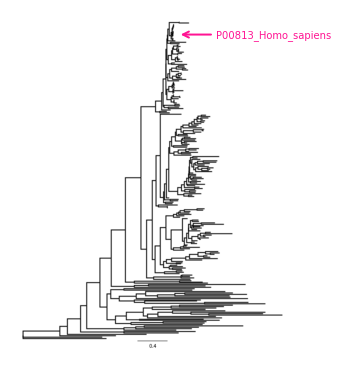

In [471]:
from data_processing import plot_image_with_arrows, plot_image_with_arrow_and_circles

img_path = 'images/ADA1_tree.png'
plot_image_with_arrows(
    img_path,
    x_starts=[0.73],
    x_ends=[0.60],
    arrow_ys=[0.045],
    labels=['P00813_Homo_sapiens'],
    text_offsets=[0.01]
)

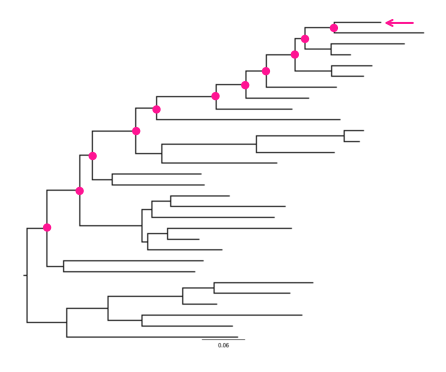

In [472]:
node_img_path = 'images/tree_nodes_example.png'
plot_image_with_arrow_and_circles(
    img_path=node_img_path,
    x_start=0.97,
    x_end=0.89,
    arrow_y=0.01,
    circle_positions=[(0.771, 0.025),(0.70,0.058),(0.675,0.105),(0.604,0.155),(0.553,0.197),
    (0.48,0.23),(0.335,0.27),(0.285,0.335),(0.178,0.41),(0.146,0.515),
    (0.066,0.625)],
    circle_radius=6
)

## Get calculated ESM2 pseudo-perplexity scores and ASR ML posterior probabilities

In [436]:
import pandas as pd
import json
import numpy as np

# Import ADA1 sequences scored for ESM2 pppl
all_scores = pd.read_csv('ADA1_all_esm2_scores_650M.csv')
all_scores = all_scores[['sequence_id', 'sequence', 'pseudo_perplexity']]

# Retrieve ML posterior probabilities from ASR run
ml_probs_json = 'ASR_outputs/ADA1_ASR/posterior_probabilities_no_gaps.json'

with open(ml_probs_json) as f:
    probs_dict = json.load(f)

all_scores['ML prob'] = all_scores['sequence_id'].apply(
    lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)

## Get phylogenetic tree with ancestral labels

In [437]:
from Bio import Phylo

tree_file = "ASR_outputs/ADA1_ASR/ancestor_tree.txt"
tree = Phylo.read(tree_file, "newick")

In [438]:
from data_processing import calc_branch_length_to_root_node, calc_branch_length_to_root_leaf

all_scores['bl_to_root'] = all_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(tree, x))


## How does ESM2 pppl vary by age of ancestors from tree root to extant sequence?

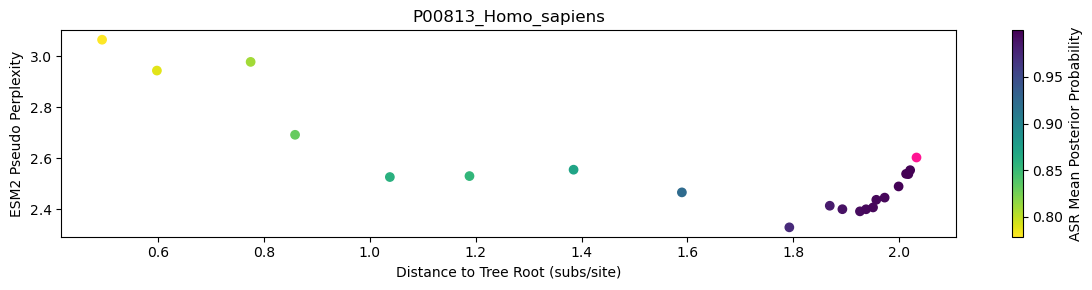

In [439]:
import matplotlib.pyplot as plt
from data_processing import get_node_labels_leaf_to_root
from data_processing import plot_evo_path

plot_evo_path(all_scores, tree, 'P00813_Homo_sapiens')

We observe a U-shaped pattern where more recent ancestral sequences have *lower* pppl scores than extant but then increases as ML support decreases with basal ancestors

## Look at other nodes in the tree

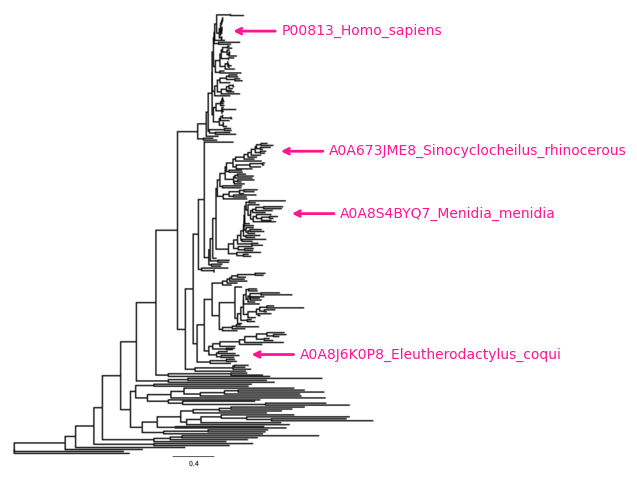

In [440]:

plot_image_with_arrows(
    img_path,
    x_starts=[0.73,0.89,0.86, 0.78],
    x_ends=[0.60,0.76,0.73, 0.65],
    arrow_ys=[0.045,0.44,0.305, 0.745],
    labels=['P00813_Homo_sapiens',  'A0A8S4BYQ7_Menidia_menidia', 'A0A673JME8_Sinocyclocheilus_rhinocerous', 'A0A8J6K0P8_Eleutherodactylus_coqui'],
    text_offsets=[0.01, 0.01, 0.01, 0.01]
)

## Do we see the same pattern for other extant sequences on the tree?

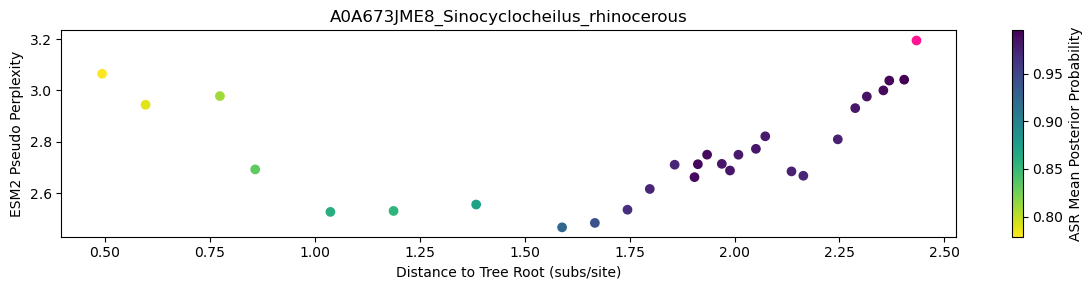

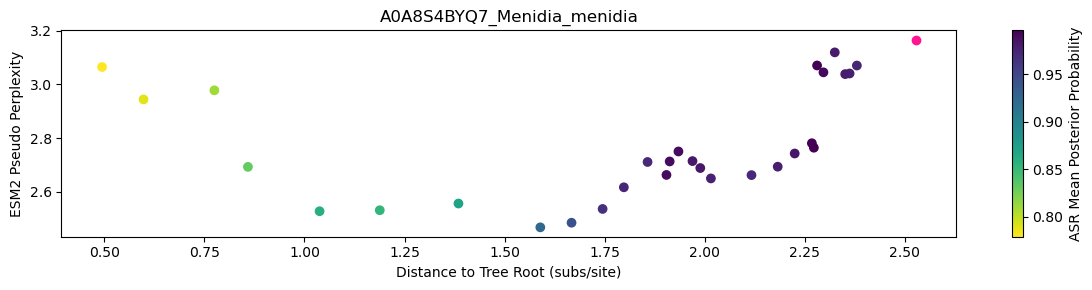

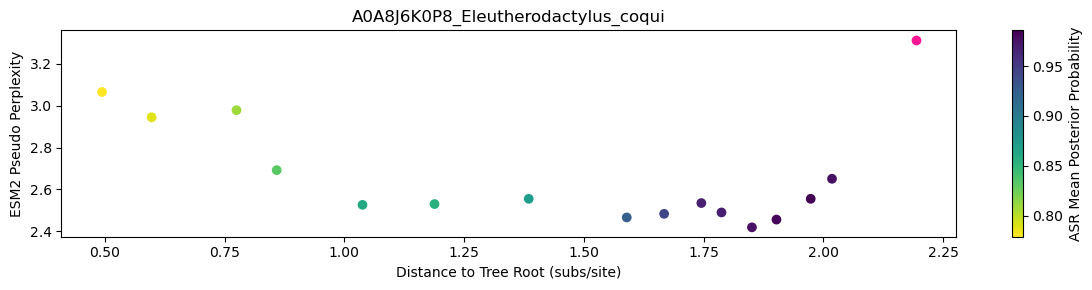

In [441]:
plot_evo_path(all_scores, tree, 'A0A673JME8_Sinocyclocheilus_rhinocerous')
plot_evo_path(all_scores, tree, 'A0A8S4BYQ7_Menidia_menidia')
plot_evo_path(all_scores, tree, 'A0A8J6K0P8_Eleutherodactylus_coqui')



Generally see the same pattern for different native ADA1 sequences on the tree

## Is the decrease in pppl for recent ancestors driven by a consensus effect?

### Generate consensus sequences

In [442]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from data_processing import generate_node_consensus, get_node_labels_leaf_to_root

leaves_of_interest = ['P00813_Homo_sapiens', 'A0A8S4BYQ7_Menidia_menidia', 'A0A673JME8_Sinocyclocheilus_rhinocerous', 'A0A8J6K0P8_Eleutherodactylus_coqui'] 
ancestors_of_interest = []

for entry in leaves_of_interest:
    ancestors_of_interest.extend(get_node_labels_leaf_to_root(tree, entry))

ancestors_of_interest = list(set(ancestors_of_interest))

alignment_file = 'ASR_outputs/ADA1_ASR/ADA1_curated_022525_under420_recoded_mafft.fa'
name_conv_dict = 'ASR_outputs/ADA1_ASR/recoding_dict.txt'
gap_dict_json = 'ASR_outputs/ADA1_ASR/gap_positions.json'

consensus_seq_file = 'consensus_ADA1_ancestors.fa'

records = []
for entry in ancestors_of_interest:
    consensus_seq = generate_node_consensus(tree, entry, alignment_file, name_conv_dict, gap_dict_json)
    name = entry + '_consensus'
    record = SeqRecord(Seq(consensus_seq), id=name, description="")
    records.append(record)

# Write all consensus sequences to a FASTA file
with open(consensus_seq_file, 'w') as file:
    SeqIO.write(records, file, "fasta")


### Get Consensus ESM2 Pseudo Perplexity Scores

In [443]:
# retrieve esm2 scores for consensus seqs
consensus_file = 'consensus_ADA1_ancestors_esm2_scores_650M.csv'
consensus_scores = pd.read_csv(consensus_file)
consensus_scores['orig_id'] = consensus_scores['sequence_id'].apply(lambda x: x.replace('_consensus', ''))
consensus_scores = consensus_scores[['orig_id', 'sequence', 'pseudo_perplexity']]
consensus_scores = consensus_scores.rename(columns={'sequence': 'consensus_seq', 'pseudo_perplexity': 'consensus_pppl', 'orig_id':'sequence_id'})


# add new consensus seqs and scores to scores df
all_scores = all_scores.merge(consensus_scores, how='left', on='sequence_id')

### Plotting

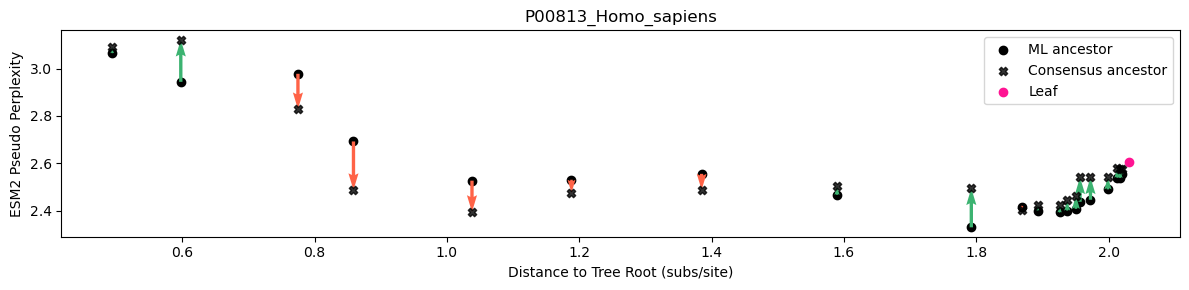

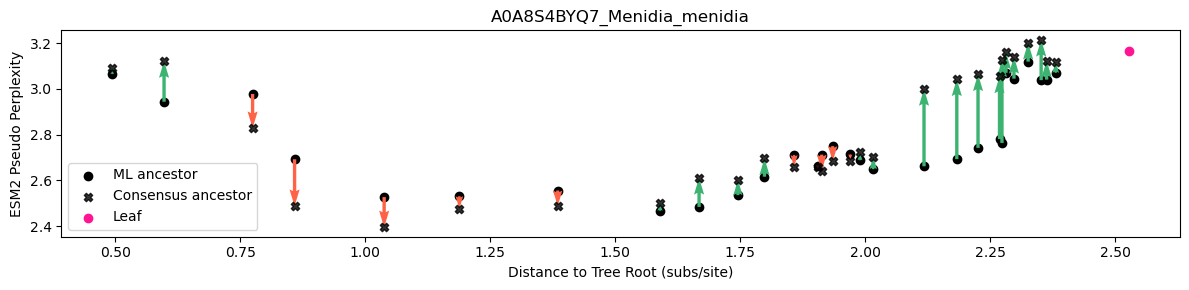

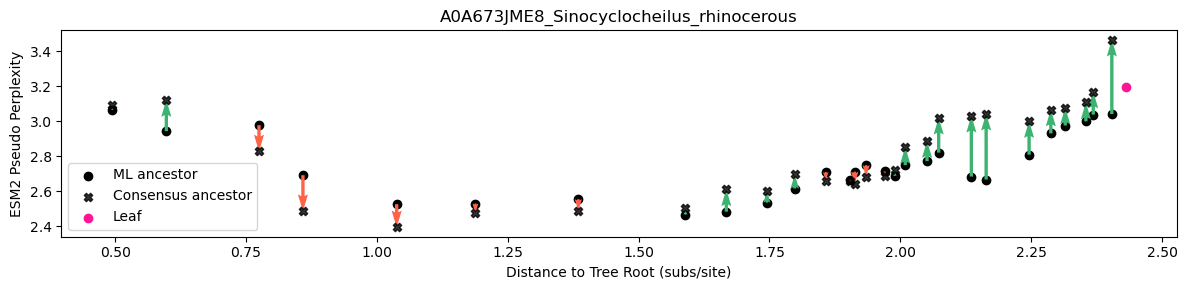

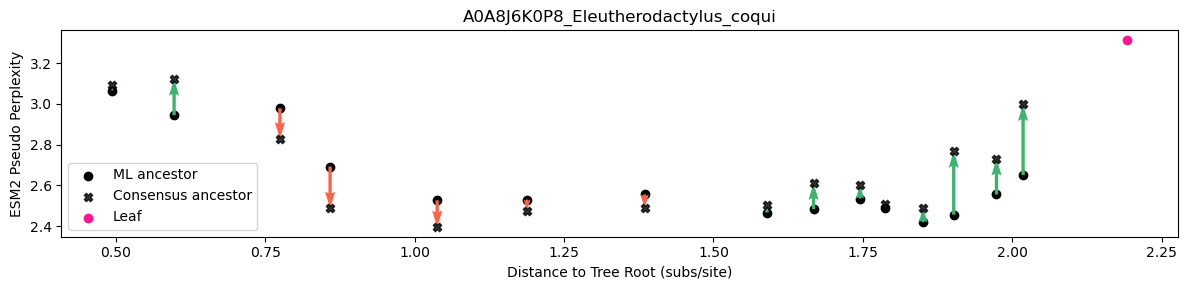

In [444]:
from data_processing import plot_evo_path_quiver

plot_evo_path_quiver(all_scores, tree, 'P00813_Homo_sapiens')
plot_evo_path_quiver(all_scores, tree, 'A0A8S4BYQ7_Menidia_menidia')
plot_evo_path_quiver(all_scores, tree, 'A0A673JME8_Sinocyclocheilus_rhinocerous')
plot_evo_path_quiver(all_scores, tree, 'A0A8J6K0P8_Eleutherodactylus_coqui')



Observe intriguing pattern where for more recent ancestors the pppl is *lower* for ML ancestors than consensus, but for older ancestors this flips.

Perhaps suggests ESM2 is actually learning some evolutionary signal and knows these low support ancestors are less plausible?

## Do smaller (or larger) models show similar behavior?

### Loading data

In [19]:
small_model_scores = pd.read_csv('ADA1_all_esm2_scores_8M.csv')
med_model_scores = pd.read_csv('ADA1_all_esm2_scores_35M.csv')
large_model_scores = pd.read_csv('ADA1_all_esm2_scores_150M.csv')
huge_model_scores = pd.read_csv('ADA1_all_esm2_scores_3B.csv')

small_model_scores['ML prob'] = small_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)
small_model_scores['bl_to_root'] = small_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(tree, x))

med_model_scores['ML prob'] = med_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)
med_model_scores['bl_to_root'] = med_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(tree, x))

large_model_scores['ML prob'] = large_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)
large_model_scores['bl_to_root'] = large_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(tree, x))

huge_model_scores['ML prob'] = huge_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)
huge_model_scores['bl_to_root'] = huge_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(tree, x))




### Results

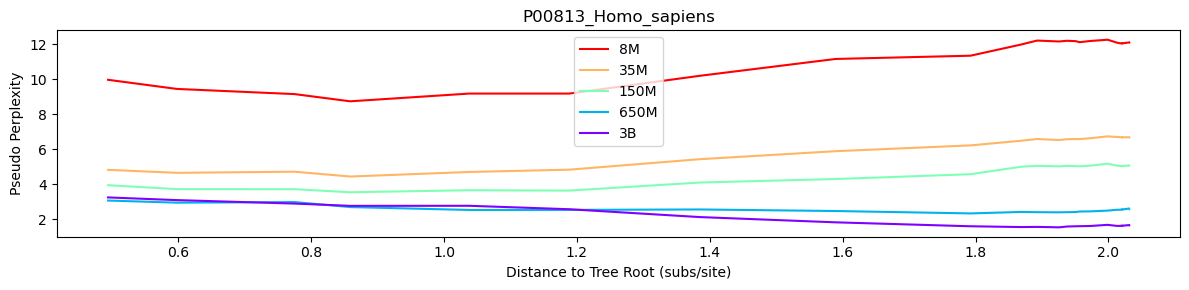

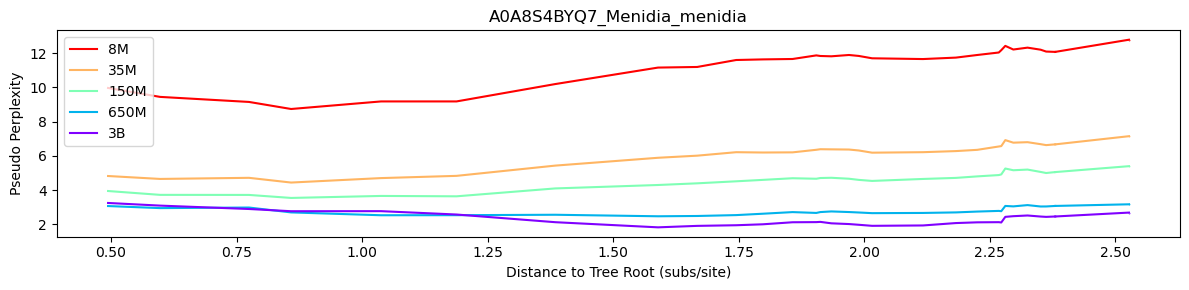

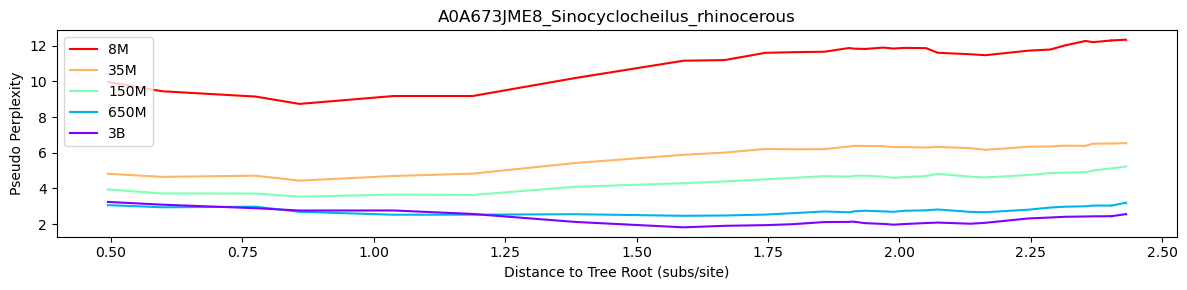

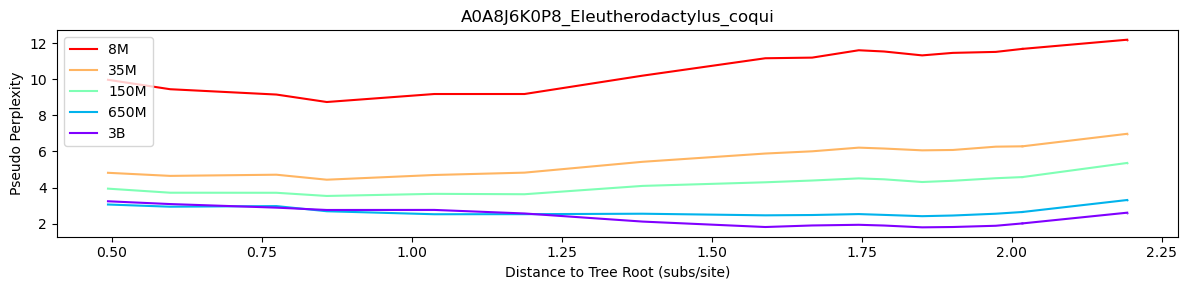

In [302]:
from data_processing import plot_multiple_evo_lines

plot_multiple_evo_lines([(small_model_scores, 'P00813_Homo_sapiens', '8M'),(med_model_scores, 'P00813_Homo_sapiens', '35M'),(large_model_scores, 'P00813_Homo_sapiens', '150M'),(all_scores, 'P00813_Homo_sapiens', '650M'),(huge_model_scores, 'P00813_Homo_sapiens', '3B')], tree, normalize = False)
plot_multiple_evo_lines([(small_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '8M'),(med_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '35M'),(large_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '150M'),(all_scores, 'A0A8S4BYQ7_Menidia_menidia', '650M'),(huge_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '3B')], tree, normalize = False)
plot_multiple_evo_lines([(small_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '8M'),(med_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '35M'),(large_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '150M'),(all_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '650M'),(huge_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '3B')], tree, normalize = False)
plot_multiple_evo_lines([(small_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '8M'),(med_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '35M'),(large_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '150M'),(all_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '650M'),(huge_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '3B')], tree, normalize = False)


Overall pppl values are lower for larger models, but the changes in relative pattern seem to differ.  Lets plot them normalized to the extant score.

### What if we normalize to extant leaf value?

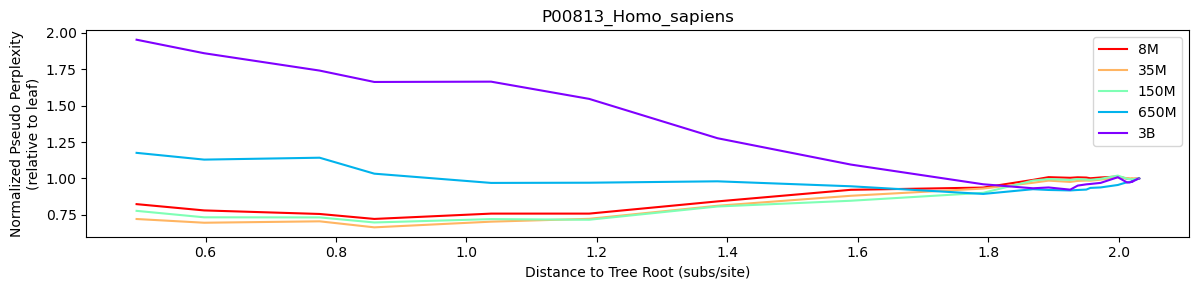

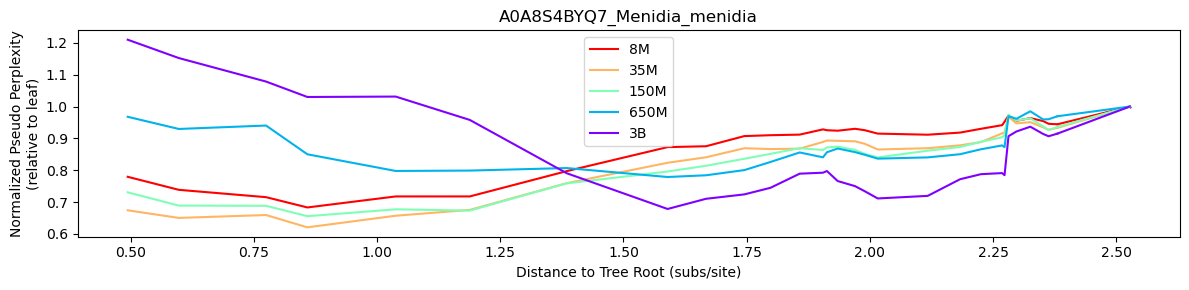

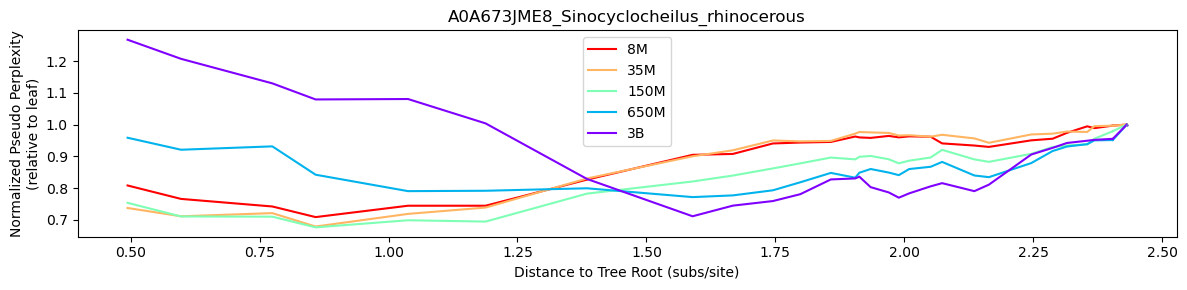

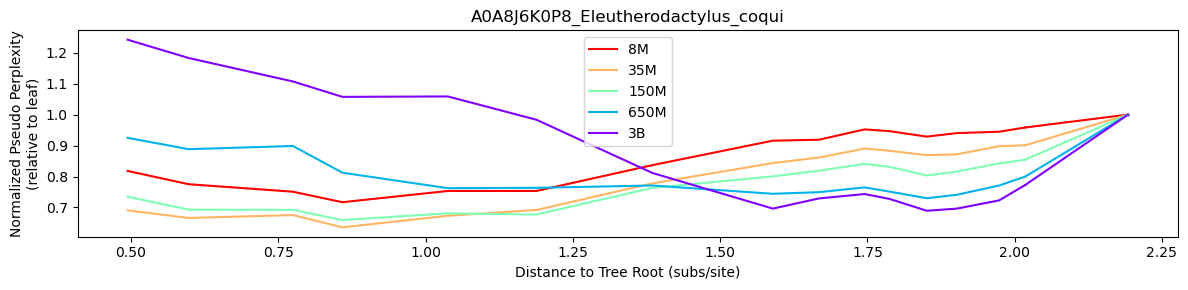

In [303]:
plot_multiple_evo_lines([(small_model_scores, 'P00813_Homo_sapiens', '8M'),(med_model_scores, 'P00813_Homo_sapiens', '35M'),(large_model_scores, 'P00813_Homo_sapiens', '150M'),(all_scores, 'P00813_Homo_sapiens', '650M'),(huge_model_scores, 'P00813_Homo_sapiens', '3B')], tree)
plot_multiple_evo_lines([(small_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '8M'),(med_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '35M'),(large_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '150M'),(all_scores, 'A0A8S4BYQ7_Menidia_menidia', '650M'),(huge_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '3B')], tree)
plot_multiple_evo_lines([(small_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '8M'),(med_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '35M'),(large_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '150M'),(all_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '650M'),(huge_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '3B')], tree)
plot_multiple_evo_lines([(small_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '8M'),(med_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '35M'),(large_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '150M'),(all_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '650M'),(huge_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '3B')], tree)



## Does this generalize to ASR of other genes?  Try yeast isomaltase as different test case

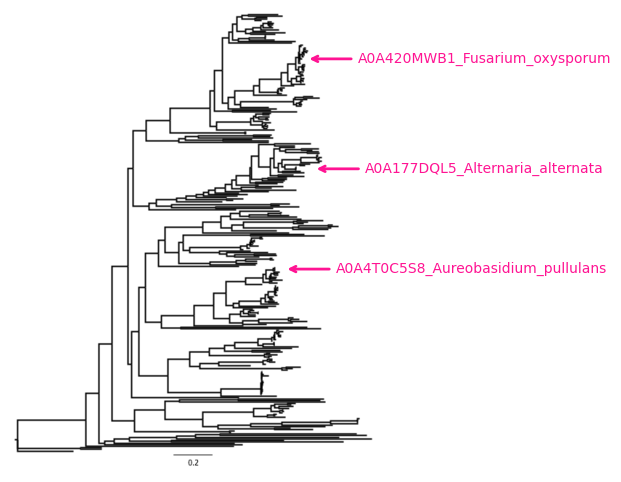

In [294]:
img_path = 'images/isomaltase_tree.png'
plot_image_with_arrows(
    img_path,
    x_starts=[0.94, 0.96, 0.88],
    x_ends=[0.81, 0.83, 0.75],
    arrow_ys=[0.105, 0.343, 0.56],
    labels=['A0A420MWB1_Fusarium_oxysporum', 'A0A177DQL5_Alternaria_alternata', 'A0A4T0C5S8_Aureobasidium_pullulans'],
    text_offsets=[0.01, 0.01, 0.01]
)

### Get ESM2 scores for isomaltase ancestors

In [451]:
# get ESM2 scores
iso_scores = pd.read_csv('isomaltase_all_esm2_scores_650M.csv')

# retrieve the dictionary of probabilities from PAML output
ml_probs_json = 'ASR_outputs/Isomaltase_ASR/posterior_probabilities_no_gaps.json'

with open(ml_probs_json) as f:
    iso_probs_dict = json.load(f)

iso_scores['ML prob'] = iso_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in iso_probs_dict[x]]) if x in iso_probs_dict else np.nan)

tree_file = "ASR_outputs/Isomaltase_ASR/ancestor_tree.txt"
iso_tree = Phylo.read(tree_file, "newick")

iso_scores['bl_to_root'] = iso_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(iso_tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(iso_tree, x))


### Plot pppl vs branch length to root

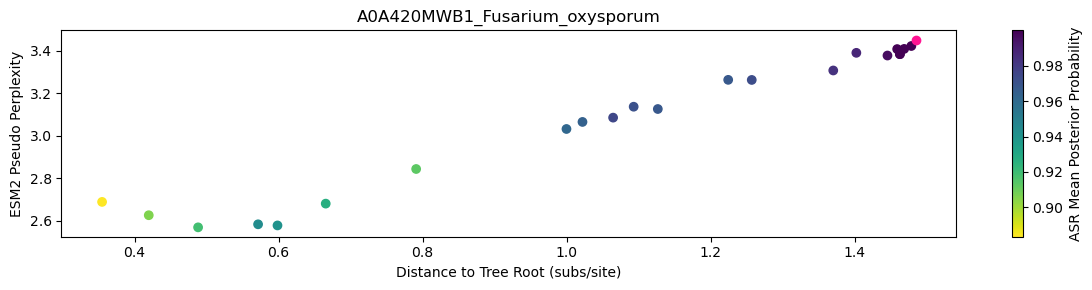

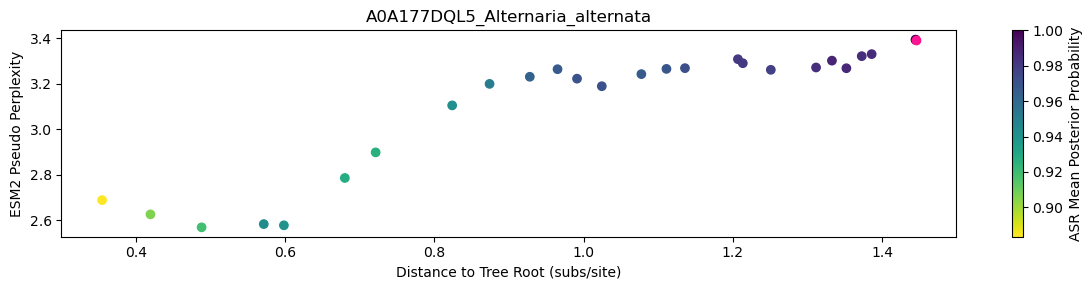

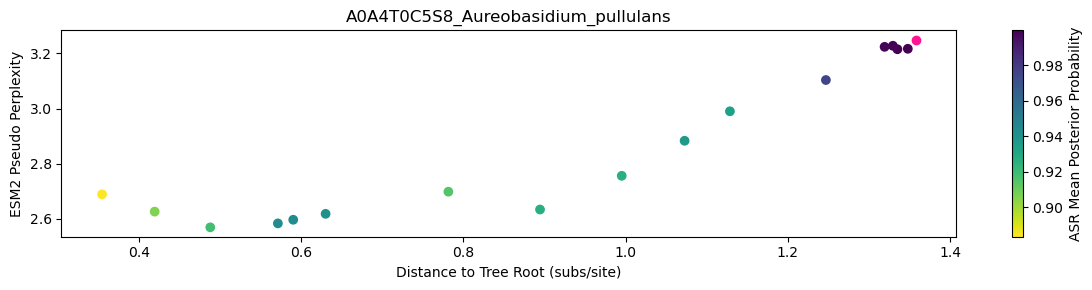

In [452]:
plot_evo_path(iso_scores, iso_tree, 'A0A420MWB1_Fusarium_oxysporum', labels=False)
plot_evo_path(iso_scores, iso_tree, 'A0A177DQL5_Alternaria_alternata', labels=False)
plot_evo_path(iso_scores, iso_tree, 'A0A4T0C5S8_Aureobasidium_pullulans', labels=False)


## Isomaltase consensus ancestors

In [453]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from data_processing import generate_node_consensus, get_node_labels_leaf_to_root

leaves_of_interest = ['A0A420MWB1_Fusarium_oxysporum', 'A0A177DQL5_Alternaria_alternata', 'A0A4T0C5S8_Aureobasidium_pullulans']
ancestors_of_interest = []

for entry in leaves_of_interest:
    ancestors_of_interest.extend(get_node_labels_leaf_to_root(iso_tree, entry))

ancestors_of_interest = list(set(ancestors_of_interest))

alignment_file = 'ASR_outputs/Isomaltase_ASR/isomaltase_dereplicated_final_recoded_mafft.fa'
name_conv_dict = 'ASR_outputs/Isomaltase_ASR/recoding_dict.txt'
gap_dict_json = 'ASR_outputs/Isomaltase_ASR/gap_positions.json'

consensus_seq_file = 'consensus_isomaltase_ancestors.fa'

records = []
for entry in ancestors_of_interest:
    consensus_seq = generate_node_consensus(iso_tree, entry, alignment_file, name_conv_dict, gap_dict_json)
    name = entry + '_consensus'
    record = SeqRecord(Seq(consensus_seq), id=name, description="")
    records.append(record)

# Write all consensus sequences to a FASTA file
with open(consensus_seq_file, 'w') as file:
    SeqIO.write(records, file, "fasta")

In [ ]:
# retrieve esm2 scores for consensus seqs
consensus_file = 'consensus_ADA1_ancestors_esm2_scores_650M.csv'
consensus_scores = pd.read_csv(consensus_file)
consensus_scores['orig_id'] = consensus_scores['sequence_id'].apply(lambda x: x.replace('_consensus', ''))
consensus_scores = consensus_scores[['orig_id', 'sequence', 'pseudo_perplexity']]
consensus_scores = consensus_scores.rename(columns={'sequence': 'consensus_seq', 'pseudo_perplexity': 'consensus_pppl', 'orig_id':'sequence_id'})


# add new consensus seqs and scores to scores df
all_scores = all_scores.merge(consensus_scores, how='left', on='sequence_id')

### Isomaltase normalized by model size

#### Retrieve data for different models

In [ ]:
# load esm2 scores for isomaltase

iso_small_model_scores = pd.read_csv('isomaltase_all_esm2_scores_8M.csv')
iso_med_model_scores = pd.read_csv('isomaltase_all_esm2_scores_35M.csv')
iso_large_model_scores = pd.read_csv('isomaltase_all_esm2_scores_150M.csv')
iso_huge_model_scores = pd.read_csv('isomaltase_all_esm2_scores_3B.csv')

iso_small_model_scores['ML prob'] = iso_small_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in iso_probs_dict[x]]) if x in iso_probs_dict else np.nan)
iso_small_model_scores['bl_to_root'] = iso_small_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(iso_tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(iso_tree, x))

iso_med_model_scores['ML prob'] = iso_med_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in iso_probs_dict[x]]) if x in iso_probs_dict else np.nan)
iso_med_model_scores['bl_to_root'] = iso_med_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(iso_tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(iso_tree, x))

iso_large_model_scores['ML prob'] = iso_large_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in iso_probs_dict[x]]) if x in iso_probs_dict else np.nan)
iso_large_model_scores['bl_to_root'] = iso_large_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(iso_tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(iso_tree, x))

iso_huge_model_scores['ML prob'] = iso_huge_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in iso_probs_dict[x]]) if x in iso_probs_dict else np.nan)
iso_huge_model_scores['bl_to_root'] = iso_huge_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(iso_tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(iso_tree, x))




#### Plot normalized pppl

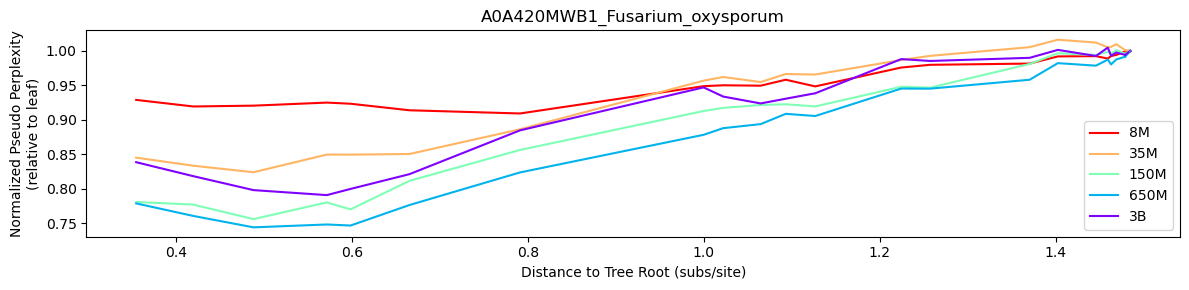

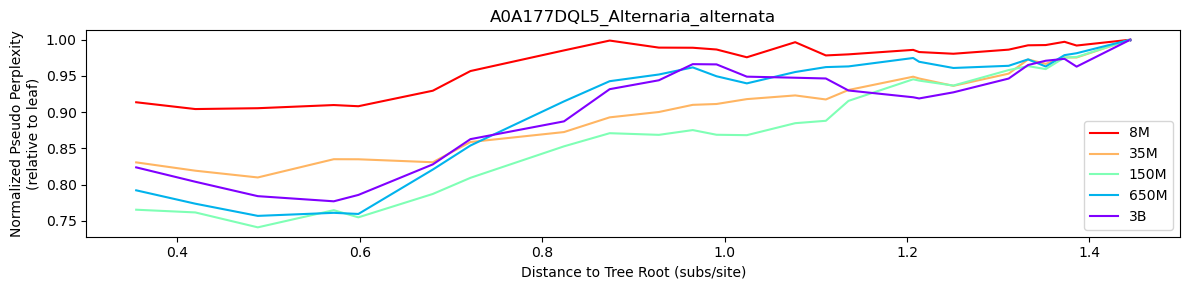

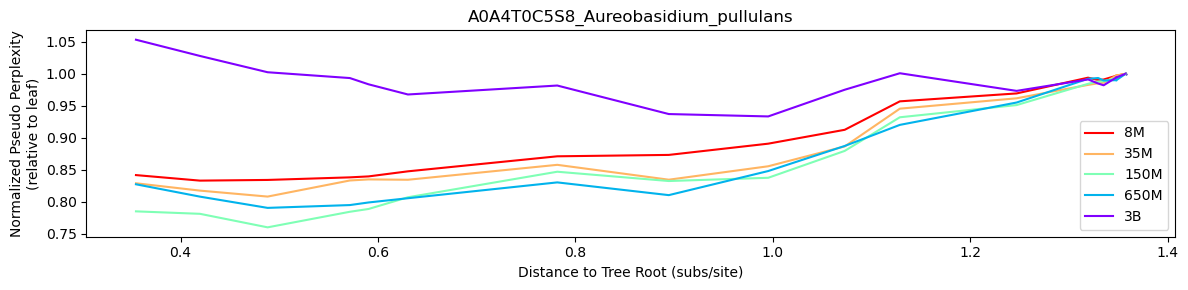

In [104]:
plot_multiple_evo_lines([(iso_small_model_scores, 'A0A420MWB1_Fusarium_oxysporum', '8M'),(iso_med_model_scores, 'A0A420MWB1_Fusarium_oxysporum', '35M'),(iso_large_model_scores, 'A0A420MWB1_Fusarium_oxysporum', '150M'),(iso_scores, 'A0A420MWB1_Fusarium_oxysporum', '650M'), (iso_huge_model_scores, 'A0A420MWB1_Fusarium_oxysporum', '3B')], iso_tree, normalize = True)
plot_multiple_evo_lines([(iso_small_model_scores, 'A0A177DQL5_Alternaria_alternata', '8M'),(iso_med_model_scores, 'A0A177DQL5_Alternaria_alternata', '35M'),(iso_large_model_scores, 'A0A177DQL5_Alternaria_alternata', '150M'),(iso_scores, 'A0A177DQL5_Alternaria_alternata', '650M'), (iso_huge_model_scores, 'A0A177DQL5_Alternaria_alternata', '3B')], iso_tree, normalize = True)
plot_multiple_evo_lines([(iso_small_model_scores, 'A0A4T0C5S8_Aureobasidium_pullulans', '8M'),(iso_med_model_scores, 'A0A4T0C5S8_Aureobasidium_pullulans', '35M'),(iso_large_model_scores, 'A0A4T0C5S8_Aureobasidium_pullulans', '150M'),(iso_scores, 'A0A4T0C5S8_Aureobasidium_pullulans', '650M'), (iso_huge_model_scores, 'A0A4T0C5S8_Aureobasidium_pullulans', '3B')], iso_tree, normalize = True)


In [463]:
# pull data for all ADA native and ancestor

remaining_df = pd.read_csv('/Users/isabel/Documents/ASR/temp_asr_plm/last_ADA1_seqs.csv')
remaining_df = remaining_df[['sequence_id', 'sequence', 'pseudo_perplexity']]

# Import ADA1 sequences scored for ESM2 pppl
all_scores = pd.read_csv('ADA1_all_esm2_scores_650M.csv')
all_scores = all_scores[['sequence_id', 'sequence', 'pseudo_perplexity']]

full_data = pd.concat([remaining_df, all_scores])

# Retrieve ML posterior probabilities from ASR run
ml_probs_json = 'ASR_outputs/ADA1_ASR/posterior_probabilities_no_gaps.json'

with open(ml_probs_json) as f:
    probs_dict = json.load(f)

full_data['ML prob'] = full_data['sequence_id'].apply(
    lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)

full_data['bl_to_root'] = full_data['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(tree, x))

full_data['ML prob'] = full_data['ML prob'].fillna(1.1)


In [459]:
full_data

,sequence_id,sequence,pseudo_perplexity,ML prob,bl_to_root
0,node326,MAEKSGKPEFDQPKIELHVHLDGAIRIKTIIEVAKRRGITLPASSE...,3.150364,0.989657,2.40859
1,node328,MAEKSGKPAFDKPKVELHVHLDGAIRIKTIVEVAKRRGITLPASSE...,3.197646,0.990196,2.40535
2,node329,MAENNGKPAFDKPKVELHVHLDGAIRIETIMDVAKRRGITLPAATV...,2.733385,0.969950,2.17105
3,node330,MAEQLAFNKPKVELHVHLDGAIRVETIMDVAKRRGMTLPAATVEEM...,2.809606,0.969025,2.30098
4,node331,MAEQLAFNKPKVELHVHLDGAIRVETIMDVAKRRGMTLPAATVDEM...,3.084499,0.996298,2.42144
...,...,...,...,...,...
191,node448,LLVLHESIANQAKCRVELHVHLDGAIRPETIWELLKQKKLPLPGDG...,4.243610,0.776858,2.11214
192,A0A7L3PJ11_Xiphorhynchus_elegans,TRVFISRKRGIPLPGDTVEELLKYVSYDTPLSLPQFLEKFNYYMPA...,5.041075,NaN,2.85211
193,A0A673JME8_Sinocyclocheilus_rhinocerous,MAENNGKPAFDKPKIELHVHLDGAIRIKTIVEVAKRRGITLPVNGE...,3.197630,NaN,2.43122
194,A0A5J4NXI4_Paragonimus_westermani,MVSGDWIRTSESVWSEEPNKMHLNNDLKGIELHLHLDGAIRPTTLF...,5.501315,NaN,3.02434


In [338]:
from data_processing import generate_node_consensus, get_node_labels_leaf_to_root

leaves_of_int = ['P00813_Homo_sapiens', 'A0A8S4BYQ7_Menidia_menidia', 'A0A673JME8_Sinocyclocheilus_rhinocerous', 'A0A5J4NXI4_Paragonimus_westermani', 'A0A8B7PF67_Hyalella_azteca', 
'A0A8J6K0P8_Eleutherodactylus_coqui', 'A0A337S152_Felis_catus', 'A0A6I9I3G5_Vicugna_pacos', 'A0A5J5MV90_Muntiacus_reevesi', 'H0V758_Cavia_porcellus', 'A0A6G1AWV2_Crocuta_crocuta',
'A0A401S233_Chiloscyllium_punctatum'] 
final_nodes = []

for entry in leaves_of_int:
    final_nodes.extend(get_node_labels_leaf_to_root(tree, entry))
    final_nodes.append(entry)

smaller_scores = all_scores[all_scores['sequence_id'].isin(final_nodes)]

all_data = pd.concat([smaller_scores, iso_scores])

In [287]:
all_scores[all_scores['pseudo_perplexity'] > 4]

,sequence_id,sequence,pseudo_perplexity,ML prob,bl_to_root,consensus_seq,consensus_pppl,ML_prob_bin
41,A0A6P6CY43_Pteropus_vampyrus,MTQTPAFDKPKVELHVHLDGAIKPETILYYGRKRGIALPASTAKEL...,5.121423,1.100000,2.23597,NaN,NaN,1.00–1.50
126,node428,MTADYDVTPRSFNLPKVELHTHLDGDVRSETILHFAKKRGIKLPAD...,4.009402,0.916437,2.11158,NaN,NaN,0.90–0.95
177,node396,RKRGVPLPGSTVDDLLKHVSYKTPLTLTQFLEKFNHYMPAIAGDRE...,5.067635,0.918912,2.49708,TRVFISRKRGIPLPGDTVEELLKYVSYDTPLSLPQFLEKFNYYMPA...,5.319318,0.90–0.95
184,node438,MFAEMHLDSDLHGVELHVHLDGSIRPETIFELAKKKGIKLPFANVE...,4.134911,0.798586,2.05430,NaN,NaN,0.75–0.80
185,node439,MFAGMHLDSDLKGVELHVHLDGSIRPETIFELAKRKGIKLPFANVE...,4.201402,0.789000,2.18719,NaN,NaN,0.75–0.80
191,node448,LLVLHESIANQAKCRVELHVHLDGAIRPETIWELLKQKKLPLPGDG...,4.243610,0.776858,2.11214,NaN,NaN,0.75–0.80
192,A0A7L3PJ11_Xiphorhynchus_elegans,TRVFISRKRGIPLPGDTVEELLKYVSYDTPLSLPQFLEKFNYYMPA...,5.041075,1.100000,2.85211,NaN,NaN,1.00–1.50
194,A0A5J4NXI4_Paragonimus_westermani,MVSGDWIRTSESVWSEEPNKMHLNNDLKGIELHLHLDGAIRPTTLF...,5.501315,1.100000,3.02434,NaN,NaN,1.00–1.50
195,A0A8B7PF67_Hyalella_azteca,MLVLHESIKKQAKCRVELHVHLDGALRPETAWDLIKQKGLPLPGDG...,5.632611,1.100000,2.71222,NaN,NaN,1.00–1.50


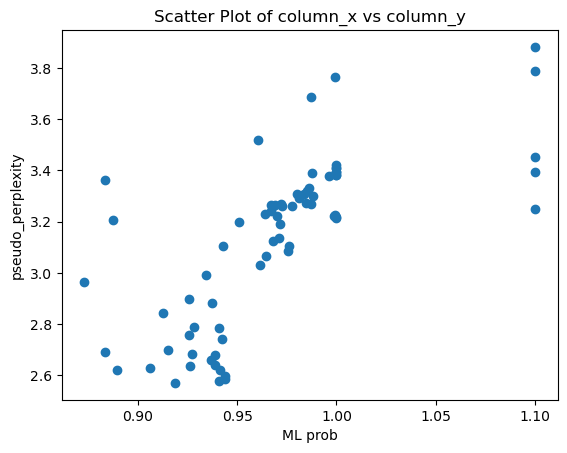

In [408]:
## Scatter plot of ML prob vs pppl


plt.scatter(iso_scores['ML prob'], iso_scores['pseudo_perplexity'])
plt.xlabel('ML prob')
plt.ylabel('pseudo_perplexity')
plt.title('Scatter Plot of column_x vs column_y')
plt.show()

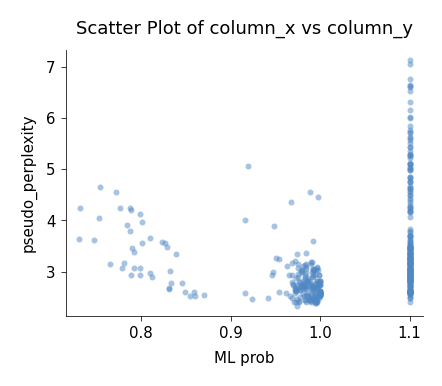

In [482]:
plt.scatter(full_data['ML prob'], full_data['pseudo_perplexity'], alpha = 0.5)
plt.xlabel('ML prob')
plt.ylabel('pseudo_perplexity')
plt.title('Scatter Plot of column_x vs column_y')
plt.show()

In [371]:
smaller_scores

,sequence_id,sequence,pseudo_perplexity,ML prob,bl_to_root,consensus_seq,consensus_pppl,ML_prob_bin
0,node238,MASVSESPVFDLPKVELHVHLDGAIRPETILDLAKKRGIELPADTV...,2.530428,0.854262,1.18818,MAENSMAQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPAD...,2.475002,0.85–0.90
1,node239,MASTSQSPVFDLPKVELHVHLDGAIRPETILHFAKKRGIKLPADTV...,2.555415,0.870550,1.38483,MAENSMAQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPAD...,2.487451,0.85–0.90
2,node240,MASMSQTPVFDKPKVELHVHLDGAIRPETILHFAKKRGIKLPADTV...,2.466517,0.923670,1.58946,MAESMAQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPADT...,2.502894,0.90–0.95
3,node241,MSQSPVFDKPKVELHVHLDGAIKPETILYYGKKRGIPLPADTVEEL...,2.329431,0.974070,1.79243,MQPGMAQTPAFDKPKVELHVHLDGAIKPETILYYGRKRGIALPADT...,2.494474,0.95–1.00
4,node242,MSQTPAFNKPKVELHVHLDGAIKPETILYYGRKRGIPLPADTVEEL...,2.414117,0.984431,1.86883,MAQTPAFDKPKVELHVHLDGAIKPETILYYGRKRGIALPADTAEEL...,2.404244,0.95–1.00
...,...,...,...,...,...,...,...,...
190,node447,LLVLHESVANPAKCRVELHVHLDGAIRPETIWELLKQKKLPLPGNG...,3.575778,0.822701,2.00015,NaN,NaN,0.80–0.85
191,node448,LLVLHESIANQAKCRVELHVHLDGAIRPETIWELLKQKKLPLPGDG...,4.243610,0.776858,2.11214,NaN,NaN,0.75–0.80
193,A0A673JME8_Sinocyclocheilus_rhinocerous,MAENNGKPAFDKPKIELHVHLDGAIRIKTIVEVAKRRGITLPVNGE...,3.197630,1.100000,2.43122,NaN,NaN,1.00–1.50
194,A0A5J4NXI4_Paragonimus_westermani,MVSGDWIRTSESVWSEEPNKMHLNNDLKGIELHLHLDGAIRPTTLF...,5.501315,1.100000,3.02434,NaN,NaN,1.00–1.50


In [403]:

leaves_of_int = ['P00813_Homo_sapiens', 'A0A8S4BYQ7_Menidia_menidia', 'A0A673JME8_Sinocyclocheilus_rhinocerous', 'A0A5J4NXI4_Paragonimus_westermani', 'A0A8B7PF67_Hyalella_azteca', 
'A0A8J6K0P8_Eleutherodactylus_coqui', 'A0A337S152_Felis_catus', 'A0A6I9I3G5_Vicugna_pacos', 'A0A5J5MV90_Muntiacus_reevesi', 'H0V758_Cavia_porcellus', 'A0A6G1AWV2_Crocuta_crocuta',
'A0A401S233_Chiloscyllium_punctatum'] 
final_nodes = []

for entry in leaves_of_int:
    final_nodes.extend(get_node_labels_leaf_to_root(tree, entry))
    final_nodes.append(entry)

small_model_scores['ML prob'] = small_model_scores['ML prob'].fillna(1.1)
med_model_scores['ML prob'] = med_model_scores['ML prob'].fillna(1.1)
large_model_scores['ML prob'] = large_model_scores['ML prob'].fillna(1.1)
huge_model_scores['ML prob'] = huge_model_scores['ML prob'].fillna(1.1)


smaller_scores = all_scores[all_scores['sequence_id'].isin(final_nodes)]
smaller_scores8 =  small_model_scores[small_model_scores['sequence_id'].isin(final_nodes)]
smaller_scores35 = med_model_scores[med_model_scores['sequence_id'].isin(final_nodes)]
smaller_scores150 = large_model_scores[large_model_scores['sequence_id'].isin(final_nodes)]
smaller_scores3 = huge_model_scores[huge_model_scores['sequence_id'].isin(final_nodes)]

iso_small_model_scores['ML prob'] = iso_small_model_scores['ML prob'].fillna(1.1)
iso_med_model_scores['ML prob'] = iso_med_model_scores['ML prob'].fillna(1.1)
iso_large_model_scores['ML prob'] = iso_large_model_scores['ML prob'].fillna(1.1)
iso_huge_model_scores['ML prob'] = iso_huge_model_scores['ML prob'].fillna(1.1)
iso_scores['ML prob'] = iso_scores['ML prob'].fillna(1.1)





/var/folders/3n/ftr5crbd3gl4fw8ncv_k48600000gn/T/ipykernel_9422/2595704951.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  input_df.groupby('ML_prob_bin')['pseudo_perplexity']


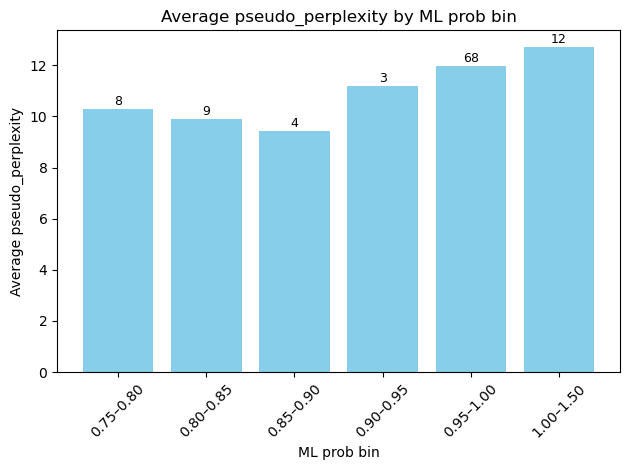

/var/folders/3n/ftr5crbd3gl4fw8ncv_k48600000gn/T/ipykernel_9422/2595704951.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  input_df.groupby('ML_prob_bin')['pseudo_perplexity']


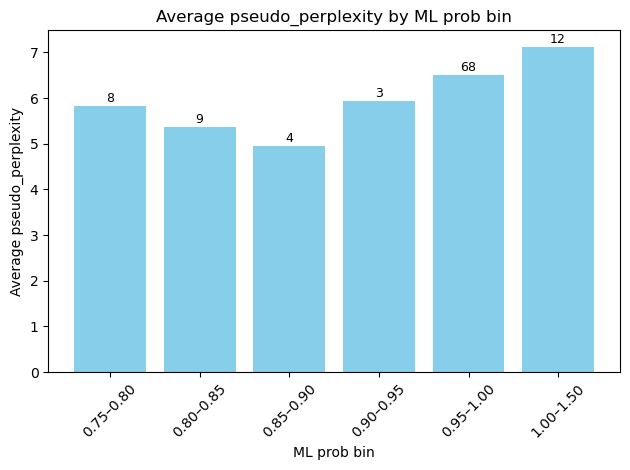

/var/folders/3n/ftr5crbd3gl4fw8ncv_k48600000gn/T/ipykernel_9422/2595704951.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  input_df.groupby('ML_prob_bin')['pseudo_perplexity']


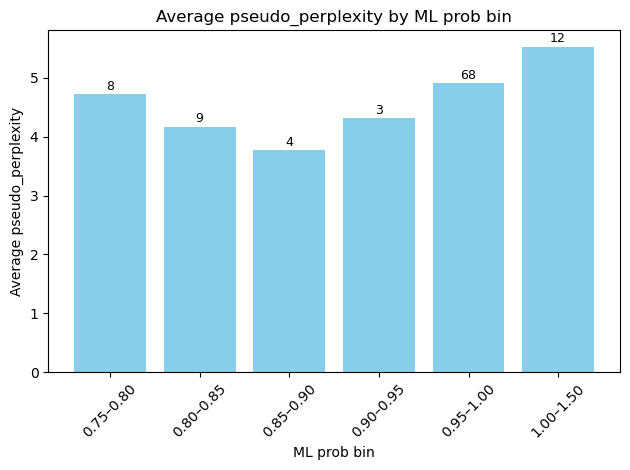

/var/folders/3n/ftr5crbd3gl4fw8ncv_k48600000gn/T/ipykernel_9422/2595704951.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  input_df.groupby('ML_prob_bin')['pseudo_perplexity']


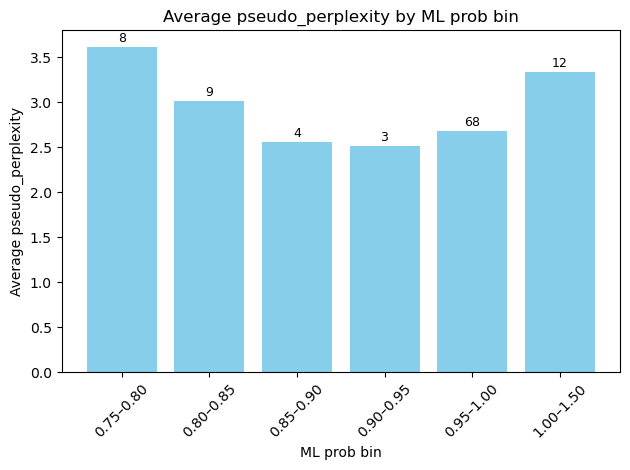

In [390]:
def bar_plot(orig_input_df):
    import matplotlib.pyplot as plt
    import pandas as pd
    input_df = orig_input_df.copy()
    bins = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.5]
    #bins = [0.7, 0.8, 0.9, 1.0, 1.1]

    labels = [f"{bins[i]:.2f}–{bins[i+1]:.2f}" for i in range(len(bins) - 1)]

    # Create the binned column
    input_df['ML_prob_bin'] = pd.cut(input_df['ML prob'], bins=bins, labels=labels, include_lowest=True)

    # Compute mean pseudo_perplexity per bin
    bin_means = (
        input_df.groupby('ML_prob_bin')['pseudo_perplexity']
        .mean()
        .reindex(labels)
    )

    # Count number of points in each bin
    bin_counts = (
        input_df['ML_prob_bin'].value_counts()
        .reindex(labels)
        .fillna(0)
        .astype(int)
    )

    # Plot
    fig, ax = plt.subplots()
    bars = ax.bar(bin_means.index, bin_means.values, color='skyblue')

    # Annotate each bar with the count
    for bar, count in zip(bars, bin_counts.values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, str(count),
                ha='center', va='bottom', fontsize=9)

    ax.set_xlabel('ML prob bin')
    ax.set_ylabel('Average pseudo_perplexity')
    ax.set_title('Average pseudo_perplexity by ML prob bin')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

bar_plot(smaller_scores8)
bar_plot(smaller_scores35)
bar_plot(smaller_scores150)
bar_plot(smaller_scores)


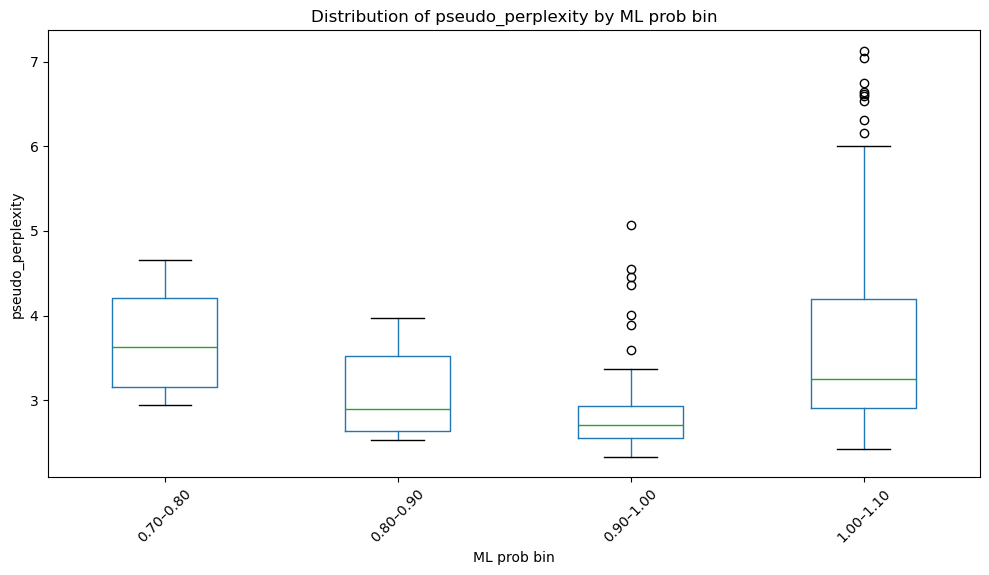

In [466]:
def box_plot(orig_input_df, violin=False):
    import matplotlib.pyplot as plt
    import pandas as pd

    input_df = orig_input_df.copy()
    bins = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.5]
    bins = [0.7, 0.8, 0.9, 1.0, 1.1]
    #bins = [0.75, 0.85, 0.95, 1.05, 1.15]
    labels = [f"{bins[i]:.2f}–{bins[i+1]:.2f}" for i in range(len(bins) - 1)]

    # Bin the ML prob values
    input_df['ML_prob_bin'] = pd.cut(input_df['ML prob'], bins=bins, labels=labels, include_lowest=True)

    # Drop rows with missing bin assignments or pseudo_perplexity
    input_df = input_df.dropna(subset=['ML_prob_bin', 'pseudo_perplexity'])

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    if violin:
        # Optional: violin plot
        input_df.boxplot(column='pseudo_perplexity', by='ML_prob_bin', ax=ax, grid=False)
        # Replace with:
        # import seaborn as sns
        # sns.violinplot(x='ML_prob_bin', y='pseudo_perplexity', data=input_df, ax=ax, inner='box')
    else:
        input_df.boxplot(column='pseudo_perplexity', by='ML_prob_bin', ax=ax, grid=False)

    ax.set_xlabel('ML prob bin')
    ax.set_ylabel('pseudo_perplexity')
    ax.set_title('Distribution of pseudo_perplexity by ML prob bin')
    plt.suptitle("")  # Remove automatic suptitle added by pandas boxplot
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

box_plot(full_data)



/var/folders/3n/ftr5crbd3gl4fw8ncv_k48600000gn/T/ipykernel_9422/4100410437.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = input_df.groupby('ML_prob_bin')['pseudo_perplexity'].agg(show_stat).values


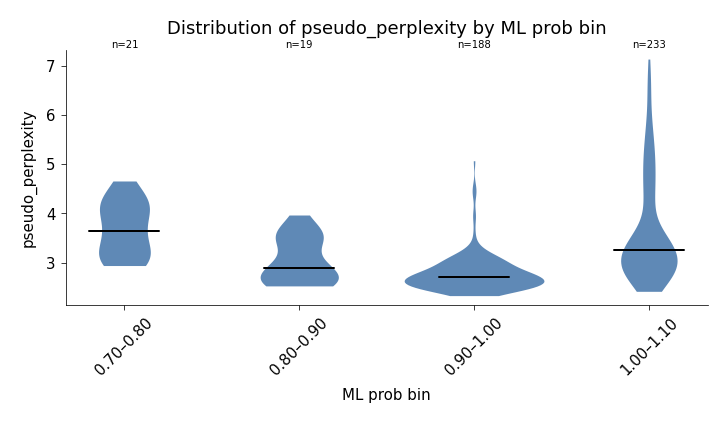

In [481]:
def box_plot(orig_input_df, violin=False, show_stat='median'):
    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sns

    input_df = orig_input_df.copy()
    bins = [0.7, 0.8, 0.9, 1.0, 1.1]
    labels = [f"{bins[i]:.2f}–{bins[i+1]:.2f}" for i in range(len(bins) - 1)]

    # Bin the ML prob values
    input_df['ML_prob_bin'] = pd.cut(input_df['ML prob'], bins=bins, labels=labels, include_lowest=True)

    # Drop rows with missing bin assignments or pseudo_perplexity
    input_df = input_df.dropna(subset=['ML_prob_bin', 'pseudo_perplexity'])

    # Count samples per bin
    bin_counts = input_df['ML_prob_bin'].value_counts().sort_index()

    # Calculate medians or means
    group_stats = input_df.groupby('ML_prob_bin')['pseudo_perplexity'].agg(show_stat).values

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    if violin:
        sns.violinplot(
            x='ML_prob_bin',
            y='pseudo_perplexity',
            data=input_df,
            ax=ax,
            inner=None,  # Don't draw inner bars; we'll add our own
            cut=0
        )

        # Add a horizontal bar for each group's stat (mean or median)
        for i, stat in enumerate(group_stats):
            ax.plot([i - 0.2, i + 0.2], [stat, stat], color='black', linewidth=2)

    else:
        input_df.boxplot(column='pseudo_perplexity', by='ML_prob_bin', ax=ax, grid=False)

    ax.set_xlabel('ML prob bin')
    ax.set_ylabel('pseudo_perplexity')
    ax.set_title('Distribution of pseudo_perplexity by ML prob bin')
    plt.suptitle("")

    # Add group sizes above the violins
    for i, (label, count) in enumerate(bin_counts.items()):
        ax.text(i, ax.get_ylim()[1], f'n={count}', ha='center', va='bottom', fontsize=10)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



box_plot(full_data, violin=True)


/var/folders/3n/ftr5crbd3gl4fw8ncv_k48600000gn/T/ipykernel_9422/3250147258.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(binned)['pseudo_perplexity']
/var/folders/3n/ftr5crbd3gl4fw8ncv_k48600000gn/T/ipykernel_9422/3250147258.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(binned)['pseudo_perplexity']
/var/folders/3n/ftr5crbd3gl4fw8ncv_k48600000gn/T/ipykernel_9422/3250147258.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fut

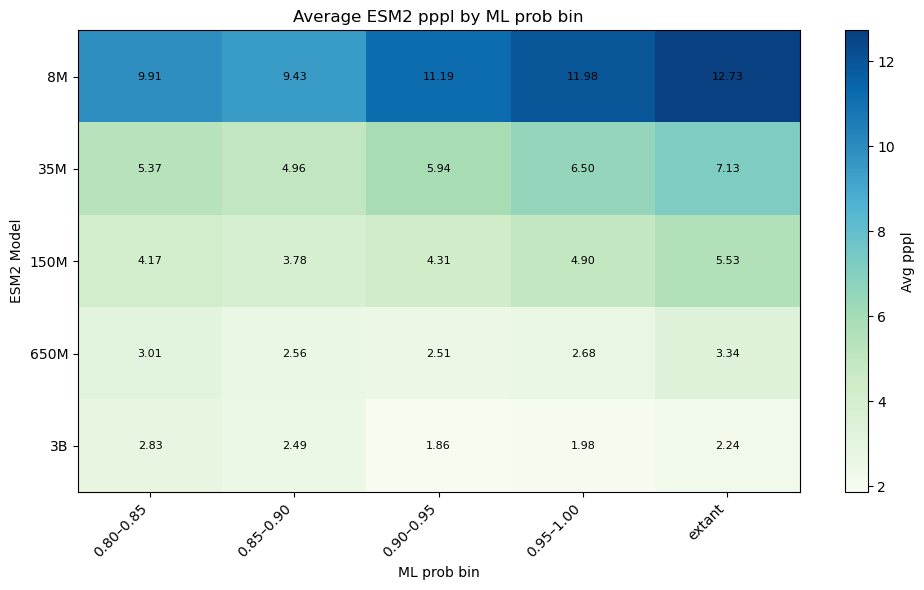

In [400]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# List of 5 example DataFrames (replace these with your actual ones)
dfs = [smaller_scores8, smaller_scores35, smaller_scores150, smaller_scores, smaller_scores3]  # Each df must contain 'ML prob' and 'pseudo_perplexity'
df_names = ['8M', '35M', '150M', '650M', '3B']


# Bin setup
bins = [0.8, 0.85, 0.9, 0.95, 1.0, 1.5]
labels = [f"{bins[i]:.2f}–{bins[i+1]:.2f}" for i in range(len(bins) - 1)]
labels[-1] = "extant"
target_bin_label = labels[-1]  # "extant"

# Compute bin means for each DataFrame
heatmap_data = []

for df in dfs:
    binned = pd.cut(df['ML prob'], bins=bins, labels=labels, include_lowest=True)
    means = (
        df.groupby(binned)['pseudo_perplexity']
        .mean()
        .reindex(labels)
    )
    heatmap_data.append(means.values)

# Convert to NumPy array for plotting
heatmap_array = np.array(heatmap_data)

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.imshow(heatmap_array, aspect='auto', cmap='GnBu')

# Show all ticks and label them
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticks(np.arange(len(df_names)))
ax.set_yticklabels(df_names)

# Annotate each cell with the value
for i in range(len(df_names)):
    for j in range(len(labels)):
        val = heatmap_array[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=8, color='black')

# Add colorbar
fig.colorbar(cax, ax=ax, label='Avg pppl')
ax.set_xlabel("ML prob bin")
ax.set_ylabel("ESM2 Model")
ax.set_title("Average ESM2 pppl by ML prob bin")
plt.tight_layout()
plt.show()



/var/folders/3n/ftr5crbd3gl4fw8ncv_k48600000gn/T/ipykernel_9422/2820168518.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(binned)['pseudo_perplexity']
/var/folders/3n/ftr5crbd3gl4fw8ncv_k48600000gn/T/ipykernel_9422/2820168518.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(binned)['pseudo_perplexity']
/var/folders/3n/ftr5crbd3gl4fw8ncv_k48600000gn/T/ipykernel_9422/2820168518.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fut

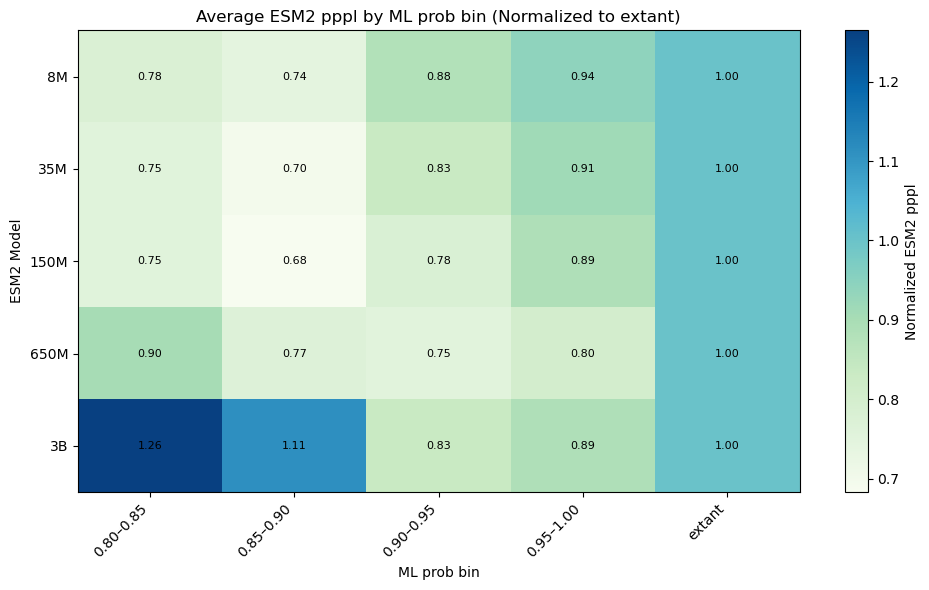

In [383]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Bin setup
bins = [0.8, 0.85, 0.9, 0.95, 1.0, 1.5]
labels = [f"{bins[i]:.2f}–{bins[i+1]:.2f}" for i in range(len(bins) - 1)]

# Replace last label with "extant"
labels[-1] = "extant"
target_bin_label = labels[-1]  # "extant"

# Compute bin means for each DataFrame
heatmap_data = []

for df in dfs:
    # Use updated labels for binning
    binned = pd.cut(df['ML prob'], bins=bins, labels=labels, include_lowest=True)
    means = (
        df.groupby(binned)['pseudo_perplexity']
        .mean()
        .reindex(labels)
    )
    heatmap_data.append(means.values)

# Convert to NumPy array
heatmap_array = np.array(heatmap_data)

# Get column index for the target bin (which is now "extant")
target_col_idx = labels.index(target_bin_label)

# Normalize each row by its own value in the >1.0 bin
normalization_factors = heatmap_array[:, target_col_idx].reshape(-1, 1)
normalized_array = heatmap_array / normalization_factors

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.imshow(normalized_array, aspect='auto', cmap='GnBu')

# Ticks and labels
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticks(np.arange(len(df_names)))
ax.set_yticklabels(df_names)

# Annotate each cell with the normalized value
for i in range(len(df_names)):
    for j in range(len(labels)):
        val = normalized_array[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=8, color='black')

# Add colorbar and labels
fig.colorbar(cax, ax=ax, label='Normalized ESM2 pppl')
ax.set_xlabel("ML prob bin")
ax.set_ylabel("ESM2 Model")
ax.set_title("Average ESM2 pppl by ML prob bin (Normalized to extant)")
plt.tight_layout()
plt.show()




In [430]:
8/0.04/60

3.3333333333333335

/var/folders/3n/ftr5crbd3gl4fw8ncv_k48600000gn/T/ipykernel_9422/2867594525.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(binned)['pseudo_perplexity']
/var/folders/3n/ftr5crbd3gl4fw8ncv_k48600000gn/T/ipykernel_9422/2867594525.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(binned)['pseudo_perplexity']
/var/folders/3n/ftr5crbd3gl4fw8ncv_k48600000gn/T/ipykernel_9422/2867594525.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fut

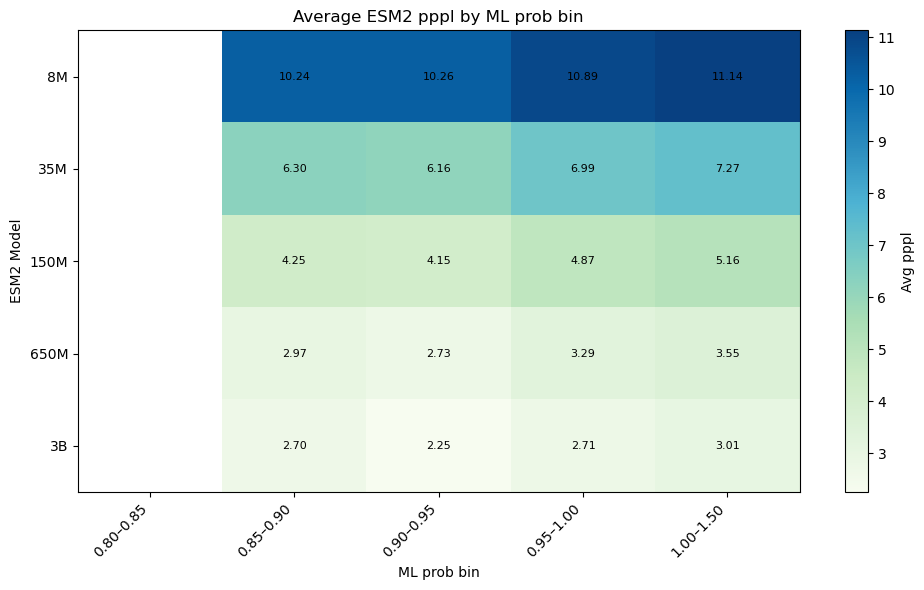

In [404]:
# List of 5 example DataFrames (replace these with your actual ones)
dfs = [iso_small_model_scores, iso_med_model_scores, iso_large_model_scores, iso_scores, iso_huge_model_scores]  # Each df must contain 'ML prob' and 'pseudo_perplexity'
df_names = ['8M', '35M', '150M', '650M', '3B']


# Bin setup
bins = [0.8, 0.85, 0.9, 0.95, 1.0, 1.5]
labels = [f"{bins[i]:.2f}–{bins[i+1]:.2f}" for i in range(len(bins) - 1)]

# Compute bin means for each DataFrame
heatmap_data = []

for df in dfs:
    binned = pd.cut(df['ML prob'], bins=bins, labels=labels, include_lowest=True)
    means = (
        df.groupby(binned)['pseudo_perplexity']
        .mean()
        .reindex(labels)
    )
    heatmap_data.append(means.values)

# Convert to NumPy array for plotting
heatmap_array = np.array(heatmap_data)

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.imshow(heatmap_array, aspect='auto', cmap='GnBu')

# Show all ticks and label them
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticks(np.arange(len(df_names)))
ax.set_yticklabels(df_names)

# Annotate each cell with the value
for i in range(len(df_names)):
    for j in range(len(labels)):
        val = heatmap_array[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=8, color='black')

# Add colorbar
fig.colorbar(cax, ax=ax, label='Avg pppl')
ax.set_xlabel("ML prob bin")
ax.set_ylabel("ESM2 Model")
ax.set_title("Average ESM2 pppl by ML prob bin")
plt.tight_layout()
plt.show()

/var/folders/3n/ftr5crbd3gl4fw8ncv_k48600000gn/T/ipykernel_9422/2820168518.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(binned)['pseudo_perplexity']
/var/folders/3n/ftr5crbd3gl4fw8ncv_k48600000gn/T/ipykernel_9422/2820168518.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(binned)['pseudo_perplexity']
/var/folders/3n/ftr5crbd3gl4fw8ncv_k48600000gn/T/ipykernel_9422/2820168518.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fut

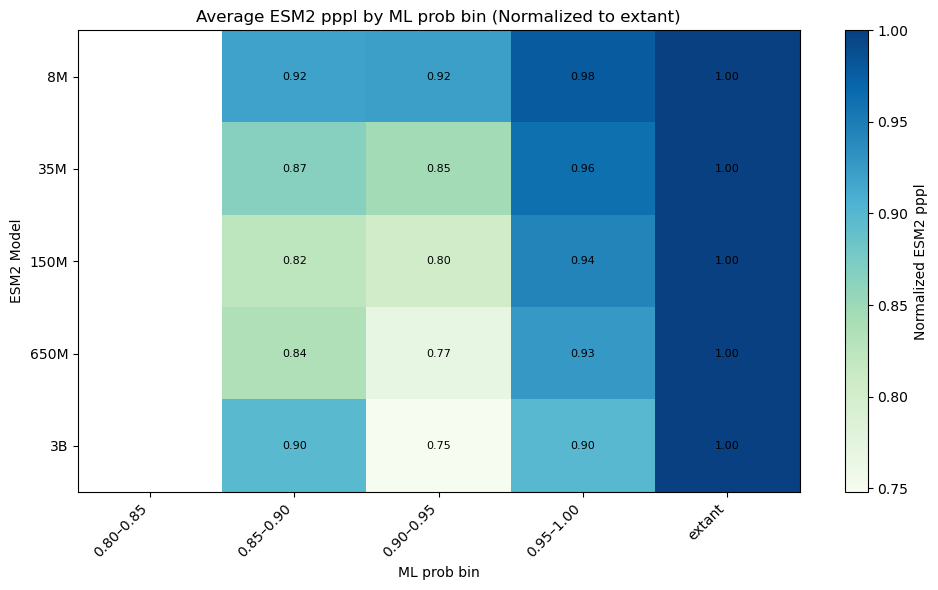

In [405]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Bin setup
bins = [0.8, 0.85, 0.9, 0.95, 1.0, 1.5]
labels = [f"{bins[i]:.2f}–{bins[i+1]:.2f}" for i in range(len(bins) - 1)]

# Replace last label with "extant"
labels[-1] = "extant"
target_bin_label = labels[-1]  # "extant"

# Compute bin means for each DataFrame
heatmap_data = []

for df in dfs:
    # Use updated labels for binning
    binned = pd.cut(df['ML prob'], bins=bins, labels=labels, include_lowest=True)
    means = (
        df.groupby(binned)['pseudo_perplexity']
        .mean()
        .reindex(labels)
    )
    heatmap_data.append(means.values)

# Convert to NumPy array
heatmap_array = np.array(heatmap_data)

# Get column index for the target bin (which is now "extant")
target_col_idx = labels.index(target_bin_label)

# Normalize each row by its own value in the >1.0 bin
normalization_factors = heatmap_array[:, target_col_idx].reshape(-1, 1)
normalized_array = heatmap_array / normalization_factors

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.imshow(normalized_array, aspect='auto', cmap='GnBu')

# Ticks and labels
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticks(np.arange(len(df_names)))
ax.set_yticklabels(df_names)

# Annotate each cell with the normalized value
for i in range(len(df_names)):
    for j in range(len(labels)):
        val = normalized_array[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=8, color='black')

# Add colorbar and labels
fig.colorbar(cax, ax=ax, label='Normalized ESM2 pppl')
ax.set_xlabel("ML prob bin")
ax.set_ylabel("ESM2 Model")
ax.set_title("Average ESM2 pppl by ML prob bin (Normalized to extant)")
plt.tight_layout()
plt.show()




/var/folders/3n/ftr5crbd3gl4fw8ncv_k48600000gn/T/ipykernel_9422/3103707933.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  iso_scores.groupby('ML_prob_bin')['pseudo_perplexity']


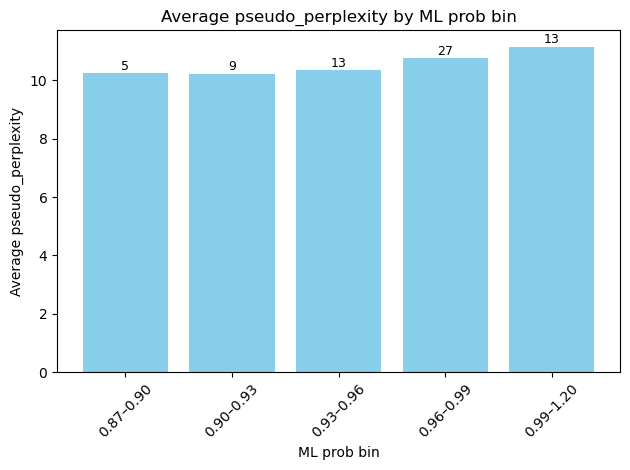

/var/folders/3n/ftr5crbd3gl4fw8ncv_k48600000gn/T/ipykernel_9422/3103707933.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  iso_scores.groupby('ML_prob_bin')['pseudo_perplexity']


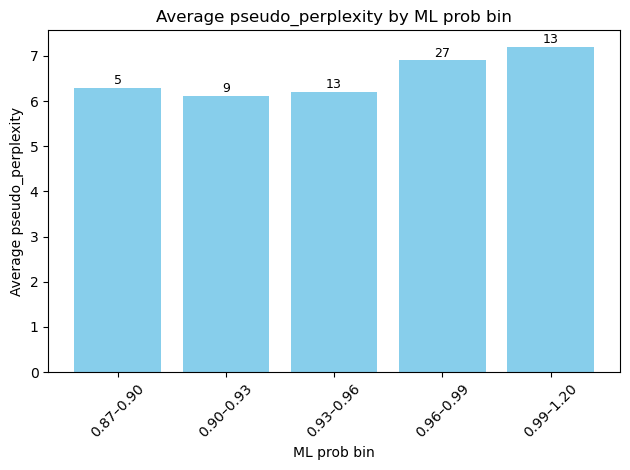

/var/folders/3n/ftr5crbd3gl4fw8ncv_k48600000gn/T/ipykernel_9422/3103707933.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  iso_scores.groupby('ML_prob_bin')['pseudo_perplexity']


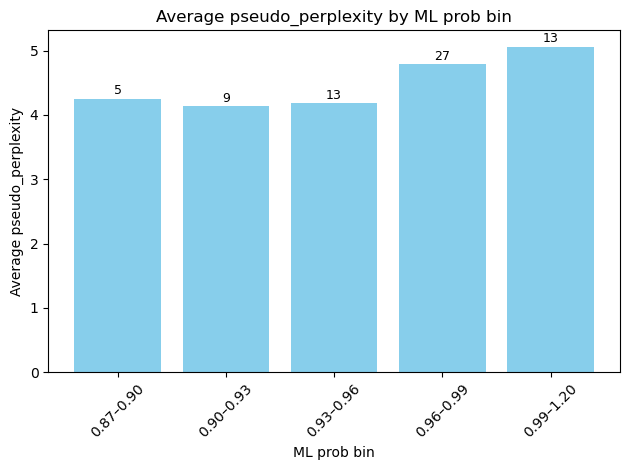

/var/folders/3n/ftr5crbd3gl4fw8ncv_k48600000gn/T/ipykernel_9422/3103707933.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  iso_scores.groupby('ML_prob_bin')['pseudo_perplexity']


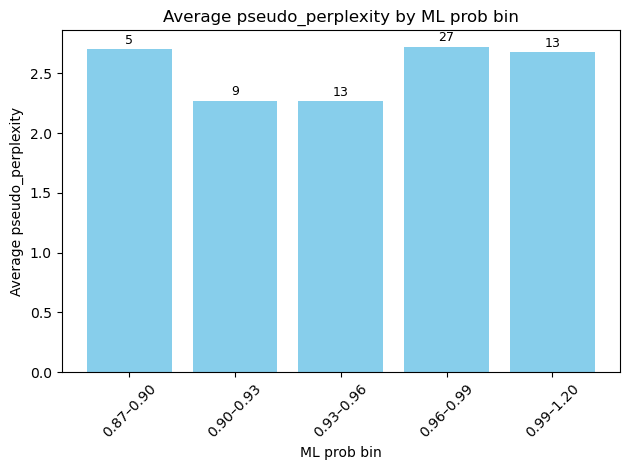

In [397]:
def heatmap_iso(orig_input_df):
    import matplotlib.pyplot as plt
    import pandas as pd

    iso_scores = orig_input_df.copy()
    bins = [0.87, 0.9, 0.93, 0.96, 0.99, 1.2, 1.5]
    #bins = [0.7, 0.8, 0.9, 1.0, 1.1]

    labels = [f"{bins[i]:.2f}–{bins[i+1]:.2f}" for i in range(len(bins) - 1)]

    # Create the binned column
    iso_scores['ML_prob_bin'] = pd.cut(iso_scores['ML prob'], bins=bins, labels=labels, include_lowest=True)

    # Compute mean pseudo_perplexity per bin
    bin_means = (
        iso_scores.groupby('ML_prob_bin')['pseudo_perplexity']
        .mean()
        .reindex(labels)
    )

    # Count number of points in each bin
    bin_counts = (
        iso_scores['ML_prob_bin'].value_counts()
        .reindex(labels)
        .fillna(0)
        .astype(int)
    )

    # Plot
    fig, ax = plt.subplots()
    bars = ax.bar(bin_means.index, bin_means.values, color='skyblue')

    # Annotate each bar with the count
    for bar, count in zip(bars, bin_counts.values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, str(count),
                ha='center', va='bottom', fontsize=9)

    ax.set_xlabel('ML prob bin')
    ax.set_ylabel('Average pseudo_perplexity')
    ax.set_title('Average pseudo_perplexity by ML prob bin')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


heatmap_iso(iso_small_model_scores)
heatmap_iso(iso_med_model_scores)
heatmap_iso(iso_large_model_scores)
heatmap_iso(iso_huge_model_scores)

In [427]:
# lets score everything on the tree that hasn't already been scored

all_scores = pd.read_csv('ADA1_all_esm2_scores_650M.csv')
all_scores = all_scores[['sequence_id', 'sequence', 'pseudo_perplexity']]

all_anc_names = [record.id for record in SeqIO.parse('ASR_outputs/ADA1_ASR/ML_ancestors.fa', 'fasta')]
all_native_names = [record.id for record in SeqIO.parse('ASR_outputs/ADA1_ASR/ADA1_curated_022525_under420.fa', 'fasta')]
all_names = all_anc_names + all_native_names

print (len(all_names))
remaining_names = [x for x in all_names if x not in all_scores['sequence_id'].to_list()]
print (len(remaining_names))

# write to fasta for scoring
with open('/Users/isabel/Documents/ASR/temp_asr_plm/last_ADA1_seqs.fa', 'w') as file:
    for record in SeqIO.parse('ASR_outputs/ADA1_ASR/ML_ancestors.fa', 'fasta'):
        if record.id in remaining_names:
            file.write(f">{record.id}\n{str(record.seq)}\n")
    for record in SeqIO.parse('ASR_outputs/ADA1_ASR/ADA1_curated_022525_under420.fa', 'fasta'):
        if record.id in remaining_names:
            file.write(f">{record.id}\n{str(record.seq)}\n")






459
265


265


In [331]:
b = all_scores[all_scores['ML prob'] <= 0.95]
b[b['ML prob']> 0.9]

,sequence_id,sequence,pseudo_perplexity,ML prob,bl_to_root,consensus_seq,consensus_pppl,ML_prob_bin
2,node240,MASMSQTPVFDKPKVELHVHLDGAIRPETILHFAKKRGIKLPADTV...,2.466517,0.923670,1.58946,MAESMAQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPADT...,2.502894,0.90–0.95
120,node307,MASTNQTPVFDKPKVELHVHLDGAIRPETILHFAKKRGIKLPADTV...,2.483728,0.942279,1.66749,MAELNSGQPVFNKPKVELHVHLDGAIRPETILDVAKKRGIPLPADT...,2.611229,0.90–0.95
122,node424,MASVNSTPVFDKPKVELHVHLDGAIRPETILHFAKKRGIKLPADTE...,2.583968,0.916262,1.76670,NaN,NaN,0.90–0.95
126,node428,MTADYDVTPRSFNLPKVELHTHLDGDVRSETILHFAKKRGIKLPAD...,4.009402,0.916437,2.11158,NaN,NaN,0.90–0.95
176,node395,RKRGVPLPGSTVDDLLKHVSYKTPLTLTQFLEKFNHYMPAIAGDRE...,3.890728,0.948146,2.36890,TRVFISRKRGVPLPGSTVDDLLKHVSYKTPLTLTQFLEKFNHYMPA...,4.440962,0.90–0.95
177,node396,RKRGVPLPGSTVDDLLKHVSYKTPLTLTQFLEKFNHYMPAIAGDRE...,5.067635,0.918912,2.49708,TRVFISRKRGIPLPGDTVEELLKYVSYDTPLSLPQFLEKFNYYMPA...,5.319318,0.90–0.95


In [330]:
a = all_scores[all_scores['ML prob'] > 0.9]
a = a[a['ML prob'] <= 0.95]
a

,sequence_id,sequence,pseudo_perplexity,ML prob,bl_to_root,consensus_seq,consensus_pppl,ML_prob_bin
2,node240,MASMSQTPVFDKPKVELHVHLDGAIRPETILHFAKKRGIKLPADTV...,2.466517,0.923670,1.58946,MAESMAQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPADT...,2.502894,0.90–0.95
120,node307,MASTNQTPVFDKPKVELHVHLDGAIRPETILHFAKKRGIKLPADTV...,2.483728,0.942279,1.66749,MAELNSGQPVFNKPKVELHVHLDGAIRPETILDVAKKRGIPLPADT...,2.611229,0.90–0.95
122,node424,MASVNSTPVFDKPKVELHVHLDGAIRPETILHFAKKRGIKLPADTE...,2.583968,0.916262,1.76670,NaN,NaN,0.90–0.95
126,node428,MTADYDVTPRSFNLPKVELHTHLDGDVRSETILHFAKKRGIKLPAD...,4.009402,0.916437,2.11158,NaN,NaN,0.90–0.95
176,node395,RKRGVPLPGSTVDDLLKHVSYKTPLTLTQFLEKFNHYMPAIAGDRE...,3.890728,0.948146,2.36890,TRVFISRKRGVPLPGSTVDDLLKHVSYKTPLTLTQFLEKFNHYMPA...,4.440962,0.90–0.95
177,node396,RKRGVPLPGSTVDDLLKHVSYKTPLTLTQFLEKFNHYMPAIAGDRE...,5.067635,0.918912,2.49708,TRVFISRKRGIPLPGDTVEELLKYVSYDTPLSLPQFLEKFNYYMPA...,5.319318,0.90–0.95


In [337]:
all_scores[all_scores['sequence_id'].str.contains('node426')]

,sequence_id,sequence,pseudo_perplexity,ML prob,bl_to_root,consensus_seq,consensus_pppl,ML_prob_bin
124,node426,MAGVTSKAVFHKPKVELHCHLDGAIRLQTILHFAKKRKIQIPAENE...,3.253512,0.954384,2.14557,NaN,NaN,0.95–1.00


In [229]:
all_native = all_scores[all_scores['sequence_id'].str.contains('_')]['sequence_id'].to_list()
all_anc =  all_scores[~all_scores['sequence_id'].str.contains('_')]['sequence_id'].to_list()

for entry in all_native:
    these_anc = get_node_labels_leaf_to_root(tree, entry)
    if len([x for x in these_anc if x in all_anc]) == len(these_anc):
        print (entry, 'complete')
    else:
        print (entry, 'missing')


A0A833Z712_Phyllostomus_discolor complete
A0A2K6BYK1_Macaca_nemestrina complete
A0A096NX92_Papio_anubis complete
A0A2K5DGX3_Aotus_nancymaae complete
A0A1U7UGV9_Carlito_syrichta complete
A0A7E6CHR4_Phyllostomus_discolor complete
H2QKE6_Pan_troglodytes complete
G3QVE6_Gorilla_gorilla complete
A0A2K5MUZ5_Cercocebus_atys complete
G1R4E9_Nomascus_leucogenys complete
A0A2K5VY31_Macaca_fascicularis complete
P00813_Homo_sapiens complete
A0A2K6UFX1_Saimiri_boliviensis complete
A0A2K5JQK6_Colobus_angolensis complete
A0A2R8ZN08_Pan_paniscus complete
A0A341BIU4_Neophocaena_asiaeorientalis complete
S9WEC0_Camelus_ferus complete
A0A2Y9PR00_Delphinapterus_leucas complete
A0A6J0Z136_Odocoileus_virginianus complete
A0A2Y9ILQ0_Enhydra_lutris complete
A0A2Y9H498_Neomonachus_schauinslandi complete
A0A7J8DEK2_Rousettus_aegyptiacus complete
A0A6P6CY43_Pteropus_vampyrus complete
A0A4U1F994_Monodon_monoceros complete
A0A340XUA0_Lipotes_vexillifer complete
A0A6I9I3G5_Vicugna_pacos complete
A0A2U3WX79_Odobenus_

In [297]:
clade_of_interest = [line.rstrip() for line in open('/users/isabel/Desktop/inner_clade.txt')]
[x for x in clade_of_interest if x in all_native]

['A0A673JME8_Sinocyclocheilus_rhinocerous',
 'A0A8J6K0P8_Eleutherodactylus_coqui',
 'A0A7L3PJ11_Xiphorhynchus_elegans',
 'A0A8S4BYQ7_Menidia_menidia']

In [268]:
all_scores[all_scores['sequence_id'].str.contains('node460')]

,sequence_id,sequence,pseudo_perplexity,ML prob,bl_to_root,consensus_seq,consensus_pppl,ML_prob_bin


In [230]:
get_node_labels_leaf_to_root(tree, 'A0A9V1G2Y5_Panthera_pardus')

['node288',
 'node287',
 'node286',
 'node278',
 'node277',
 'node261',
 'node246',
 'node245',
 'node244',
 'node243',
 'node242',
 'node241',
 'node240',
 'node239',
 'node238',
 'node237',
 'node236',
 'node235',
 'node234',
 'node233']

In [ ]:
get_node_labels_leaf_to_root(tree, 'A0A7L3PJ11_Xiphorhynchus_elegans')

['node396',
 'node395',
 'node393',
 'node392',
 'node391',
 'node389',
 'node388',
 'node387',
 'node386',
 'node379',
 'node378',
 'node377',
 'node308',
 'node307',
 'node240',
 'node239',
 'node238',
 'node237',
 'node236',
 'node235',
 'node234',
 'node233']

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the bins for 'ML prob' (you can adjust these)
bins = [0.7, 0.74, 0.78, 0.82, 0.86, 0.90, 0.94, 0.96, 0.98, 1.0]
#bins = 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0
labels = [str(x) for x in bins[0:-1]]

# Create a new column for the bin labels
iso_scores['ML_prob_bin'] = pd.cut(iso_scores['ML prob'], bins=bins, labels=labels, include_lowest=True)

# Compute the mean pseudo_perplexity for each bin
bin_means = iso_scores.groupby('ML_prob_bin')['pseudo_perplexity'].mean()

# Plot as a bar chart
plt.bar(bin_means.index, bin_means.values, color='skyblue')

plt.xlabel('ML prob bin')
plt.ylabel('Average pseudo_perplexity')
plt.title('Average pseudo_perplexity by ML prob bin')
plt.show()

array([0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05])

In [ ]:
import matplotlib.pyplot as plt

# Example list of sequence IDs to highlight
highlight_ids = get_node_labels_leaf_to_root(tree, '')

# Create a boolean mask
is_highlighted = all_scores['sequence_id'].isin(highlight_ids)

# Plot non-highlighted points in default color (e.g., gray)
plt.scatter(
    all_scores.loc[~is_highlighted, 'bl_to_root'],
    all_scores.loc[~is_highlighted, 'pseudo_perplexity'],
    color='gray', label='Other Sequences'
)

# Plot highlighted points in pink
plt.scatter(
    all_scores.loc[is_highlighted, 'bl_to_root'],
    all_scores.loc[is_highlighted, 'pseudo_perplexity'],
    color='pink', label='Highlighted Sequences'
)

plt.xlabel('bl_to_root')
plt.ylabel('pseudo_perplexity')
plt.title('Scatter Plot of bl_to_root vs pseudo_perplexity')
plt.legend()
plt.show()


,sequence_id,sequence,pseudo_perplexity,ML prob,bl_to_root,consensus_seq,consensus_pppl
0,node238,MASVSESPVFDLPKVELHVHLDGAIRPETILDLAKKRGIELPADTV...,2.530428,0.854262,1.18818,MAENSMAQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPAD...,2.475002
1,node239,MASTSQSPVFDLPKVELHVHLDGAIRPETILHFAKKRGIKLPADTV...,2.555415,0.870550,1.38483,MAENSMAQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPAD...,2.487451
2,node240,MASMSQTPVFDKPKVELHVHLDGAIRPETILHFAKKRGIKLPADTV...,2.466517,0.923670,1.58946,MAESMAQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPADT...,2.502894
3,node241,MSQSPVFDKPKVELHVHLDGAIKPETILYYGKKRGIPLPADTVEEL...,2.329431,0.974070,1.79243,MQPGMAQTPAFDKPKVELHVHLDGAIKPETILYYGRKRGIALPADT...,2.494474
4,node242,MSQTPAFNKPKVELHVHLDGAIKPETILYYGRKRGIPLPADTVEEL...,2.414117,0.984431,1.86883,MAQTPAFDKPKVELHVHLDGAIKPETILYYGRKRGIALPADTAEEL...,2.404244
...,...,...,...,...,...,...,...
191,node448,LLVLHESIANQAKCRVELHVHLDGAIRPETIWELLKQKKLPLPGDG...,4.243610,0.776858,2.11214,NaN,NaN
192,A0A7L3PJ11_Xiphorhynchus_elegans,TRVFISRKRGIPLPGDTVEELLKYVSYDTPLSLPQFLEKFNYYMPA...,5.041075,NaN,2.85211,NaN,NaN
193,A0A673JME8_Sinocyclocheilus_rhinocerous,MAENNGKPAFDKPKIELHVHLDGAIRIKTIVEVAKRRGITLPVNGE...,3.197630,NaN,2.43122,NaN,NaN
194,A0A5J4NXI4_Paragonimus_westermani,MVSGDWIRTSESVWSEEPNKMHLNNDLKGIELHLHLDGAIRPTTLF...,5.501315,NaN,3.02434,NaN,NaN


In [ ]:
plt.scatter(large_model_scores['ML prob'], large_model_scores['pseudo_perplexity'])
plt.xlabel('ML prob')
plt.ylabel('pseudo_perplexity')
plt.title('Scatter Plot of column_x vs column_y')
plt.grid(True)
plt.show()

In [107]:
iso_scores

,sequence_id,sequence,length,perplexity,mean_log_prob,pseudo_perplexity,mean_pll,pll,ML prob,bl_to_root
0,node289,MSAMTSTERKWWKDAVVYQIWPASFKDSNGDGIGDIPGIISTLDYL...,586,1.162602,-0.150661,2.689004,-0.989171,-579.654179,0.883418,0.35482
1,node290,MSAMTTTERKWWKDAVVYQIYPASFKDSNGDGIGDIPGIISKLDYL...,586,1.153428,-0.142739,2.626391,-0.965611,-565.847910,0.905957,0.41964
2,node298,MSAMTTTERKWWKDAVVYQIYPASFKDSNGDGIGDIPGIISKLDYL...,581,1.152250,-0.141717,2.569368,-0.943660,-548.266347,0.918831,0.48816
3,node299,MSAMTTTERKWWKDAVVYQIYPASFKDSNGDGIGDIPGIISKLDYI...,580,1.155459,-0.144497,2.583657,-0.949206,-550.539362,0.943686,0.57146
4,node300,MSAMTTTERKWWKDAVVYQIYPASFKDSNGDGIGDIPGIISKLDYI...,581,1.154748,-0.143882,2.578382,-0.947162,-550.301144,0.941052,0.59842
...,...,...,...,...,...,...,...,...,...,...
67,A0A4T0C5S8_Aureobasidium_pullulans,MGFTSAQSGSEVQQTGQHPWWKEATVYQIYPASFNDSNDDGIGDIP...,592,1.225355,-0.203230,3.249637,-1.178543,-697.697624,NaN,1.35736
68,A0A420MWB1_Fusarium_oxysporum,MTVSRRSKQWWKQAIIYQIYPASFCDSNGDGMGDLQGIISKLDYIA...,594,1.236968,-0.212663,3.451863,-1.238914,-735.914964,NaN,1.48459
69,A0A1C1CJQ6_Cladophialophora_carrionii,MIEILRQQHDRKWWKEAVVYQIYPASFKDSNGDGVGDIPGIISKLD...,586,1.289560,-0.254301,3.883211,-1.356662,-795.004135,NaN,1.34494
70,A0A177DQL5_Alternaria_alternata,MTVPQRPWWKDGVVYQIYPASFKDSNGDGIGDLNGIISELDYIRSI...,576,1.238829,-0.214167,3.393889,-1.221976,-703.858366,NaN,1.44475


## Can visualizing the ESM2 embeddings help us understand the evolutionary relationships?

### Results for smaller model 

In [ ]:
model_to_plot = model_dfs[-1]

plot_evo_path_quiver(model_to_plot, tree, 'P00813_Homo_sapiens')
plot_evo_path_quiver(model_to_plot, tree, 'A0A8S4BYQ7_Menidia_menidia')
plot_evo_path_quiver(model_to_plot, tree, 'A0A673JME8_Sinocyclocheilus_rhinocerous')
plot_evo_path_quiver(model_to_plot, tree, 'A0A8J6K0P8_Eleutherodactylus_coqui')
plot_evo_path_quiver(model_to_plot, tree, 'A0A7L3PJ11_Xiphorhynchus_elegans')


## ESMfold tell us anything about these ancestors?

In [ ]:
### Measure ADA1 ESMfold scores

# get all nodes
all_nodes = []
extant_list = ['P00813_Homo_sapiens','A0A4U1F994_Monodon_monoceros', 'A0A8S4BYQ7_Menidia_menidia', 'A0A673JME8_Sinocyclocheilus_rhinocerous', 'A0A8J6K0P8_Eleutherodactylus_coqui', 'A0A7L3PJ11_Xiphorhynchus_elegans']
for entry in extant_list:
    all_nodes.extend(get_node_labels_leaf_to_root(tree, entry))

all_nodes.extend(extant_list)
all_nodes = list(set(all_nodes))

# first get ESMfold structures
esmfold_folder = '/Users/isabel/Documents/ASR/temp_asr_plm/esmfold/'
with open(esmfold_folder + 'ADA1_seqs_for_esmfold.fa', 'w') as file:
    for index, row in all_scores.iterrows():
        if row['sequence_id'] in all_nodes:
            file.write(f">{row['sequence_id']}\n{row['sequence']}\n")


In [ ]:
import os
def extract_ca_plddt(pdb_file):
    """Extract CA atom pLDDT scores from a PDB file."""
    plddt_dict = {}
    with open(pdb_file, 'r') as f:
        for line in f:
            if line.startswith('ATOM') and line[12:16].strip() == 'CA':
                chain_id = line[21].strip()
                resnum = int(line[22:26].strip())
                b_factor = float(line[60:66].strip())
                plddt_dict[(chain_id, resnum)] = b_factor
    return plddt_dict

folded_anc = ['esmfold/predicted_structures/' + file for file in os.listdir('esmfold/predicted_structures/')]
esmfold_scores_dict = {}
low_esm_fold_scores_dict = {}
threshold = 0.6
for entry in folded_anc:
    esmfold_scores_dict[entry.split('/')[-1].split('.')[0]] = float(np.mean(list(extract_ca_plddt(entry).values())))
    low_esm_fold_scores_dict[entry.split('/')[-1].split('.')[0]] =  len([x for x in list(extract_ca_plddt(entry).values()) if x < threshold])/len(list(extract_ca_plddt(entry).values()))

In [ ]:
len([x for x in list(extract_ca_plddt(entry).values()) if x > 0.9])/len(list(extract_ca_plddt(entry).values()))

In [ ]:
all_scores['esmfold_plddt'] = all_scores['sequence_id'].apply(lambda x: esmfold_scores_dict[x] if x in esmfold_scores_dict else np.nan)
all_scores['esmfold_low_plddt'] = all_scores['sequence_id'].apply(lambda x: low_esm_fold_scores_dict[x] if x in low_esm_fold_scores_dict else np.nan)

In [ ]:
all_scores

In [ ]:
def plot_evo_path_esmfold(scores_df, tree, leaf_name, labels = False):
    these_nodes = get_node_labels_leaf_to_root(tree, leaf_name)

    # Subset the relevant data
    for_plot = scores_df[scores_df['sequence_id'].isin(these_nodes)]

    plt.figure(figsize=(12, 3))

    # Scatter plot with color representing ML probability
    scatter = plt.scatter(
        for_plot['bl_to_root'],
        for_plot['esmfold_low_plddt'],
        c=for_plot['ML prob'],
        cmap='viridis_r',
        marker='o'
    )

    #Add labels for each point using the sequence_id
    if labels == True: 
        for i, row in for_plot.iterrows():
            plt.text(
                row['bl_to_root'],
                row['esmfold_low_plddt'],
                row['sequence_id'],
                fontsize=9,
                ha='right',
                va='bottom'
            )


    # Add the leaf point in pink
    x = calc_branch_length_to_root_leaf(tree, leaf_name)
    y = scores_df[scores_df['sequence_id'] == leaf_name]['esmfold_low_plddt'].to_list()[0]
    plt.scatter(x, y, color='deeppink', label='Leaf', zorder=10)

    # Add colorbar
    plt.colorbar(scatter, label='ASR Mean Posterior Probability')

    # Labels and layout
    plt.xlabel('Distance to Tree Root (subs/site)')
    plt.ylabel('ESMfold plddt')
    plt.title(leaf_name)
    plt.tight_layout()
    plt.show()

plot_evo_path_esmfold(all_scores, tree, 'P00813_Homo_sapiens')

In [ ]:
# make histogram of plddt scores instead of just mean


# # Extract pLDDT values
# node233_plddt = list(extract_ca_plddt('esmfold/predicted_structures/node233.pdb').values())
# human_plddt = list(extract_ca_plddt('esmfold/predicted_structures/p00813-homo-sapiens.pdb').values())
# node245_plddt = list(extract_ca_plddt('esmfold/predicted_structures/node245.pdb').values())

# # Combine all data to compute shared bins
# all_plddt = node233_plddt + human_plddt + node245_plddt
# min_val, max_val = min(all_plddt), max(all_plddt)
# bins = np.linspace(min_val, max_val, 21)  # 10 equal-width bins

# # Plot histograms with shared bins
# plt.hist(node233_plddt, bins=bins, alpha=0.6, label='node233')
# plt.hist(human_plddt, bins=bins, alpha=0.6, label='human')
# plt.hist(node245_plddt, bins=bins, alpha=0.6, label='node245')

# plt.ylabel('esmfold pLDDT count')
# plt.xlabel('pLDDT')
# plt.legend()
# plt.show()


# print (len([x for x in node233_plddt if x < 0.5]))
# print (len([x for x in node245_plddt if x < 0.5]))
# print (len([x for x in human_plddt if x < 0.5]))



In [ ]:
# plot plddt across protein

plt.figure(figsize=(12, 4))
plt.plot(node233_plddt, label='Node233')
plt.plot(human_plddt, label='Human')
plt.plot(node245_plddt, label='Node245')
plt.xlabel('Residue Position')
plt.ylabel('pLDDT')
plt.title('Residue-level Confidence from ESMFold')
plt.legend()
plt.tight_layout()
plt.show()


## Thornton epistasis paper provide any ground truth?


In [ ]:
thornton_esm = '/Users/isabel/Documents/Evolvability/thornton_data/thornton_anc.csv'
more_thornton = '/Users/isabel/Documents/Evolvability/thornton_data/thornton_more.csv'

thornton_df1 = pd.read_csv(thornton_esm)
thornton_df2 = pd.read_csv(more_thornton)

thornton_df = pd.concat([thornton_df1, thornton_df2], ignore_index=True)

# mapping nodes to names
node_mapping = {'AncSR1': '399', 'AncSR':'376', 'AncNR3':'332', 'AncSco':'392', 'AncPro':'379', 'AncSed':'391', 'AncAnn':'387', 'HumanGR': 'H_sapiens_GR', 'CteletaSR': 'C_teleta_ER'}

thornton_df['real_name'] = thornton_df['sequence_id'].apply(lambda x: 'node' + node_mapping[x] if 'Anc' in x else node_mapping[x] if 'node' not in x else x)
thornton_df = thornton_df[['real_name', 'pseudo_perplexity', 'sequence']]

# rename columns
thornton_df = thornton_df.rename(columns={'real_name': 'sequence_id'})
thornton_df


In [ ]:
# add branch lengths into table
orig_rooted_tree = '/Users/isabel/Documents/Evolvability/thornton_data/my_parsed_paml_outputs/ancestor_tree.txt'
thornton_tree = Phylo.read(orig_rooted_tree, 'newick')

thornton_df['bl_to_root'] = thornton_df['sequence_id'].apply(lambda x: 0 if x == 'node222' else calc_branch_length_to_root_node(thornton_tree, x[4:]) if 'node' in x else calc_branch_length_to_root_leaf(thornton_tree, x))

thornton_df


In [ ]:
# add ML probs
ml_probs_json = '/Users/isabel/Documents/Evolvability/thornton_data/my_parsed_paml_outputs/posterior_probabilities.json'

with open(ml_probs_json, "r") as f:
    probs_dict = json.load(f)

thornton_df['ML prob'] = thornton_df['sequence_id'].apply(lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)

In [ ]:
plot_evo_path(thornton_df, thornton_tree, 'H_sapiens_GR', labels = True)
plot_evo_path(thornton_df, thornton_tree, 'C_teleta_ER', labels = True)

In [ ]:
# Compare to consensus sequences

alignment_file = ''

name_conv_dict = '/Users/isabel/Documents/ASR/ADA1_ASR/022525_run/recoding_dict.txt'
gap_dict_json = '/Users/isabel/Documents/ASR/ADA1_ASR/022525_run/gap_positions.json'

consensus_seq_file = '/Users/isabel/Documents/ESM2/consensus_seqs.fa'

with open(consensus_seq_file, 'w') as file:
    for entry in ancestors_of_interest:
        consensus_seq = generate_node_consensus(tree, entry, alignment_file, name_conv_dict, gap_dict_json)
        name = entry + '_consensus'
        file.write('>' + name + '\n' + consensus_seq + '\n')



In [ ]:
# look at thornton fitness data

thornton_fitness_df = pd.read_csv('/Users/isabel/Documents/Evolvability/thornton_data/Supplementary files/dF.txt', sep = ' ')

# add in name of wt
mapping_df = pd.read_csv('/Users/isabel/Documents/Evolvability/thornton_data/Supplementary files/Notes.txt', sep = ':')
# rename 1st column
mapping_df.rename(columns = {mapping_df.columns[0]: 'anc_number'}, inplace = True)
mapping_df.rename(columns = {mapping_df.columns[1]: 'anc_name'}, inplace = True)
mapping_dict = mapping_df.set_index('anc_number')['anc_name'].to_dict()

# add new column that maps name from mapping_df to df
thornton_fitness_df['anc_name'] = thornton_fitness_df['PROT'].apply(lambda x: mapping_dict[str(x)])
thornton_fitness_df['anc_name'] = thornton_fitness_df['anc_name'].str.replace(' ', '')

# get rid of log10 and average
thornton_fitness_df['F1_actual'] = thornton_fitness_df['F1'].apply(lambda x: 10**float(x))
thornton_fitness_df['F2_actual'] = thornton_fitness_df['F2'].apply(lambda x: 10**float(x))
thornton_fitness_df['F3_actual'] = thornton_fitness_df['F3'].apply(lambda x: 10**float(x))
thornton_fitness_df['ave_F_actual'] = thornton_fitness_df[['F1_actual', 'F2_actual', 'F3_actual']].mean(axis=1)


#Identify wild-type rows
wt = thornton_fitness_df[thornton_fitness_df['WTAA'] == thornton_fitness_df['MTAA']].copy()
wt = wt[['anc_name', 'ave_F_actual']].rename(columns={'avg_fitness': 'WT_F_avg'})
wt = wt[~wt['anc_name'].str.contains('Alt')]

# average wt
wt = thornton_fitness_df[thornton_fitness_df['WTAA'] == thornton_fitness_df['MTAA']].copy()
result = wt.groupby('anc_name', as_index=False)['ave_F_actual'].mean()
result = result.rename(columns={'avg_fitness': 'ave_ave_fitness'})


result

In [ ]:


order_ctel = ['C.teletaSR', 'ScolecidSR', 'SedentarianSR', 'AnnelidSR', 'ProtostomeSR', 'AncSR', 'AncNR3']
order_human = ['HumanGR', 'AncSR1', 'AncSR', 'AncNR3']


for entry in order_human:
    print (entry, ':', result[result['anc_name'] == entry]['ave_F_actual'].to_list()[0])
    



In [ ]:
len(all_nodes)

In [ ]:
plt.hist(thornton_fitness_df['ave_F_actual'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Average Fitness')
plt.ylabel('Count')
plt.title('Histogram of avg_fitness')
plt.show()

## Thioredoxin dataset as ground truth?

In [ ]:
# load in perplexity scores

trx_8M = pd.read_csv('TRX_ASR_paper/Trx_8M.csv')
trx_8M = trx_8M[['sequence_id', 'pseudo_perplexity']].rename(columns={'pseudo_perplexity': 'pppl_8M'})

trx_35M = pd.read_csv('TRX_ASR_paper/Trx_35M.csv')
trx_35M = trx_35M[['sequence_id', 'pseudo_perplexity']].rename(columns={'pseudo_perplexity': 'pppl_35M'})

trx_150M = pd.read_csv('TRX_ASR_paper/Trx_150M.csv')
trx_150M = trx_150M[['sequence_id', 'pseudo_perplexity']].rename(columns={'pseudo_perplexity': 'pppl_150M'})

trx_650M = pd.read_csv('TRX_ASR_paper/Trx_650M.csv')
trx_650M = trx_650M[['sequence_id', 'pseudo_perplexity']].rename(columns={'pseudo_perplexity': 'pppl_650M'})

trx_3B = pd.read_csv('TRX_ASR_paper/Trx_3B.csv')
trx_3B = trx_3B[['sequence_id', 'pseudo_perplexity']].rename(columns={'pseudo_perplexity': 'pppl_3B'})

# Merge all on sequence_id
trx_df = trx_8M.merge(trx_35M, on='sequence_id') \
               .merge(trx_150M, on='sequence_id') \
               .merge(trx_650M, on='sequence_id') \
               .merge(trx_3B, on='sequence_id')

# add in age and fitness scores
trx_fitness_df = pd.read_csv('TRX_ASR_paper/Trx_fitness.csv')
trx_fitness_df

trx_df = trx_df.merge(trx_fitness_df, on='sequence_id')

trx_df['sequence_id'] = trx_df['sequence_id'].apply(lambda x: x.replace(' ', ''))
trx_df


In [ ]:
plt.figure(figsize=(10, 6))
plot_list = ['LBCA_Trx', 'LPBCA_Trx', 'LGPCA_Trx', 'E_coli_Trx']
#plot_list =['AECA_Trx', 'LECA_Trx', 'LAFCA_Trx', 'Human_Trx']
plot_df = trx_df[trx_df['sequence_id'].isin(plot_list)].copy()

# Normalize pppl values (min-max) for each model size
pppl_cols = ['pppl_8M', 'pppl_35M', 'pppl_150M', 'pppl_650M', 'pppl_3B']
for col in pppl_cols:
    min_val = trx_df[col].min()
    max_val = trx_df[col].max()
    plot_df[col] = (plot_df[col] - min_val) / (max_val - min_val)

# Plot normalized values
plt.figure(figsize=(10, 6))
plt.scatter(plot_df['Age'], plot_df['pppl_8M'],     label='8M')
plt.scatter(plot_df['Age'], plot_df['pppl_35M'],    label='35M')
plt.scatter(plot_df['Age'], plot_df['pppl_150M'],   label='150M')
plt.scatter(plot_df['Age'], plot_df['pppl_650M'],   label='650M')
plt.scatter(plot_df['Age'], plot_df['pppl_3B'],     label='3B')

plt.xlabel('Age (Gyr)')
plt.ylabel('Normalized Pseudo-Perplexity')
plt.title('Normalized Pseudo-Perplexity vs Age for Different Model Sizes')
plt.legend(title='Model Size')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
trx_df

In [ ]:
plt.scatter(plot_df['Age'], plot_df['Tm'])

In [ ]:
plot_df

In [ ]:
get_node_labels_leaf_to_root(tree, 'P00813_Homo_sapiens')

In [ ]:
all_scores.to_csv('/Users/isabel/Documents/ASR/temp_asr_plm/ADA1_all_scores.csv')

In [ ]:
all_scores

,sequence_id,sequence,pseudo_perplexity,ML prob,bl_to_root,consensus_seq_x,consensus_pppl_x,consensus_seq_y,consensus_pppl_y,consensus_seq,consensus_pppl
0,node238,MASVSESPVFDLPKVELHVHLDGAIRPETILDLAKKRGIELPADTV...,2.530428,0.854262,1.18818,MAENSMAQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPAD...,2.475002,MAENSMAQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPAD...,2.475002,MAENSMAQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPAD...,2.475002
1,node239,MASTSQSPVFDLPKVELHVHLDGAIRPETILHFAKKRGIKLPADTV...,2.555415,0.870550,1.38483,MAENSMAQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPAD...,2.487451,MAENSMAQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPAD...,2.487451,MAENSMAQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPAD...,2.487451
2,node240,MASMSQTPVFDKPKVELHVHLDGAIRPETILHFAKKRGIKLPADTV...,2.466517,0.923670,1.58946,MAESMAQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPADT...,2.502894,MAESMAQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPADT...,2.502894,MAESMAQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPADT...,2.502894
3,node241,MSQSPVFDKPKVELHVHLDGAIKPETILYYGKKRGIPLPADTVEEL...,2.329431,0.974070,1.79243,MQPGMAQTPAFDKPKVELHVHLDGAIKPETILYYGRKRGIALPADT...,2.494474,MQPGMAQTPAFDKPKVELHVHLDGAIKPETILYYGRKRGIALPADT...,2.494474,MQPGMAQTPAFDKPKVELHVHLDGAIKPETILYYGRKRGIALPADT...,2.494474
4,node242,MSQTPAFNKPKVELHVHLDGAIKPETILYYGRKRGIPLPADTVEEL...,2.414117,0.984431,1.86883,MAQTPAFDKPKVELHVHLDGAIKPETILYYGRKRGIALPADTAEEL...,2.404244,MAQTPAFDKPKVELHVHLDGAIKPETILYYGRKRGIALPADTAEEL...,2.404244,MAQTPAFDKPKVELHVHLDGAIKPETILYYGRKRGIALPADTAEEL...,2.404244
...,...,...,...,...,...,...,...,...,...,...,...
191,node448,LLVLHESIANQAKCRVELHVHLDGAIRPETIWELLKQKKLPLPGDG...,4.243610,0.776858,2.11214,NaN,NaN,NaN,NaN,NaN,NaN
192,A0A7L3PJ11_Xiphorhynchus_elegans,TRVFISRKRGIPLPGDTVEELLKYVSYDTPLSLPQFLEKFNYYMPA...,5.041075,NaN,2.85211,NaN,NaN,NaN,NaN,NaN,NaN
193,A0A673JME8_Sinocyclocheilus_rhinocerous,MAENNGKPAFDKPKIELHVHLDGAIRIKTIVEVAKRRGITLPVNGE...,3.197630,NaN,2.43122,NaN,NaN,NaN,NaN,NaN,NaN
194,A0A5J4NXI4_Paragonimus_westermani,MVSGDWIRTSESVWSEEPNKMHLNNDLKGIELHLHLDGAIRPTTLF...,5.501315,NaN,3.02434,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
full_consensus_df = pd.read_csv('/Users/isabel/Documents/ESM2/consensus_seqs.csv')
full_consensus_df

,sequence_id,sequence,length,perplexity,mean_log_prob,pseudo_perplexity,mean_pll,pll
0,node392_consensus,QVELHVHLDGAIRPETILHFGRKRGVPLPGSTVDDLLKHVSYKTPL...,348,1.195048,-0.178186,2.687380,-0.988567,-344.021269
1,node233_consensus,MAENCSMSQTPTLLASFADKAAAFVSRRAALPKVELHVHLDGAIRP...,372,1.203962,-0.185618,3.091120,-1.128533,-419.814422
2,node236_consensus,MAENSMSQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPAD...,356,1.138516,-0.129725,2.486869,-0.911025,-324.324779
3,node243_consensus,MAQTPAFDKPKVELHVHLDGAIKPETILYYGRKRGIALPADTAEEL...,363,1.174574,-0.160906,2.422194,-0.884674,-321.136631
4,node242_consensus,MAQTPAFDKPKVELHVHLDGAIKPETILYYGRKRGIALPADTAEEL...,362,1.173271,-0.159796,2.404244,-0.877235,-317.559198
...,...,...,...,...,...,...,...,...
69,node340_consensus,MHIARRAAIGFGSPVLSSLTGRLSTMAELSSEQVVFNKPKVELHVH...,388,1.205541,-0.186928,3.042355,-1.112632,-431.701184
70,node395_consensus,TRVFISRKRGVPLPGSTVDDLLKHVSYKTPLTLTQFLEKFNHYMPA...,328,1.310260,-0.270226,4.440962,-1.490871,-489.005716
71,node241_consensus,MQPGMAQTPAFDKPKVELHVHLDGAIKPETILYYGRKRGIALPADT...,366,1.183115,-0.168151,2.494474,-0.914078,-334.552562
72,node238_consensus,MAENSMAQTPAFDKPKVELHVHLDGAIRPETILYVAKKRGIALPAD...,361,1.155330,-0.144386,2.475002,-0.906241,-327.153068


In [ ]:
consensus_of_interest = []
my_leaves = ['']

In [ ]:
# create matching esm2 scores for consensus seqs

consensus_of_interest = [str(x) + '_consensus' for x in consensus_of_interest]

output_file = 'consensus_ADA1_ancestors_esm2_scores.csv'
full_consensus_df = pd.read_csv('/Users/isabel/Documents/ESM2/consensus_seqs.csv')
flag = []
with open(output_file, 'w') as file:
    for index, row in full_consensus_df.iterrows():
        if row['sequence_id'] in consensus_of_interest:
            flag.append(1)
        else:
            flag.append(0)

full_consensus_df['include'] = flag
include_df = full_consensus_df[full_consensus_df['include'] == 1]
include_df.drop(columns=['include'], inplace=True)
include_df.to_csv(output_file, index = False)

/var/folders/3n/ftr5crbd3gl4fw8ncv_k48600000gn/T/ipykernel_89399/113168279.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  include_df.drop(columns=['include'], inplace=True)


In [ ]:
row['sequence_id']

'node267_consensus'

In [ ]:
consensus_of_interest

['node257_consensus',
 'node256_consensus',
 'node251_consensus',
 'node250_consensus',
 'node248_consensus',
 'node247_consensus',
 'node246_consensus',
 'node245_consensus',
 'node244_consensus',
 'node243_consensus',
 'node242_consensus',
 'node241_consensus',
 'node240_consensus',
 'node239_consensus',
 'node238_consensus',
 'node237_consensus',
 'node236_consensus',
 'node235_consensus',
 'node234_consensus',
 'node233_consensus',
 'node353_consensus',
 'node352_consensus',
 'node351_consensus',
 'node350_consensus',
 'node349_consensus',
 'node348_consensus',
 'node343_consensus',
 'node342_consensus',
 'node341_consensus',
 'node340_consensus',
 'node339_consensus',
 'node338_consensus',
 'node315_consensus',
 'node314_consensus',
 'node313_consensus',
 'node312_consensus',
 'node311_consensus',
 'node310_consensus',
 'node309_consensus',
 'node308_consensus',
 'node307_consensus',
 'node240_consensus',
 'node239_consensus',
 'node238_consensus',
 'node237_consensus',
 'node236_

In [ ]:
consensus_of_interest = []
for entry in ['P00813_Homo_sapiens',  'A0A8S4BYQ7_Menidia_menidia', 'A0A673JME8_Sinocyclocheilus_rhinocerous', 'A0A7L3PJ11_Xiphorhynchus_elegans']:
    consensus_of_interest.extend(get_node_labels_leaf_to_root(tree, entry))

#consensus_of_interest = ['node' + str(x) for x in consensus_of_interest]

In [ ]:
# # write different size models to single file


# df1 = pd.read_csv('/Users/isabel/Documents/ASR/temp_asr_plm/human_remaining_3B.csv')
# df2 = pd.read_csv('/Users/isabel/Documents/ASR/temp_asr_plm/human_2more_3B.csv')
# df3 = pd.read_csv('/Users/isabel/Documents/ASR/temp_asr_plm/human_just3_3B.csv')
# df4 = pd.read_csv('/Users/isabel/Documents/ASR/temp_asr_plm/remaining_ADA1_3B.csv')
# huge_model_scores = pd.concat([df1, df2, df3, df4])

# huge_model_scores.to_csv('ADA1_all_esm2_scores_3B.csv')